In [1]:
# only for standard_env, not ps_msc
# from tf_bind_8_dataset import TFBind8Dataset

In [2]:
import torch
if torch.cuda.is_available():
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')
else:
    print('No GPU found')

Using GPU: NVIDIA GeForce GTX 1660 SUPER


In [3]:
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.lines import Line2D
import os
import re
import numpy as np
from collections import defaultdict
import random
import json

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd

In [5]:
from ps_functions.mlp_model import train_mlp_from_config
from ps_functions.cnn_model import train_cnn_from_config
from ps_functions.lstm_model import train_lstm_from_config
from ps_functions.lstm_cnn_model import train_lstm_cnn_from_config
from ps_functions.cnn_lstm_model import train_cnn_lstm_from_config
from ps_functions.transformer_model import train_transformer_from_config
from ps_functions.evaluate_best_models import run_evaluation
from ps_functions.evaluate_best_models import predict_y_values

In [6]:
print('toggle')

toggle


## Data Loading

In [7]:
class TFBind8Dataset():
    def __init__(self):
        self.x = np.load(os.path.join('data', 'x_SIX6_REF_R1.npy'))
        self.y = np.load(os.path.join('data', 'y_SIX6_REF_R1.npy'))

dataset = TFBind8Dataset()
len(dataset.x)

65792

In [8]:
# dataset = TFBind8Dataset(
#     base_path='C:/Users/kroep/Desktop/AI/ps_master_new/code/data_from_huggingface/',
#     transcription_factor="SIX6_REF_R1"
# )

# import os
# import numpy as np
# np.save(os.path.join('data', 'x_SIX6_REF_R1.npy'), dataset.x)   # save x array
# np.save(os.path.join('data', 'y_SIX6_REF_R1.npy'), dataset.y)   # save x array

## Data Analysis

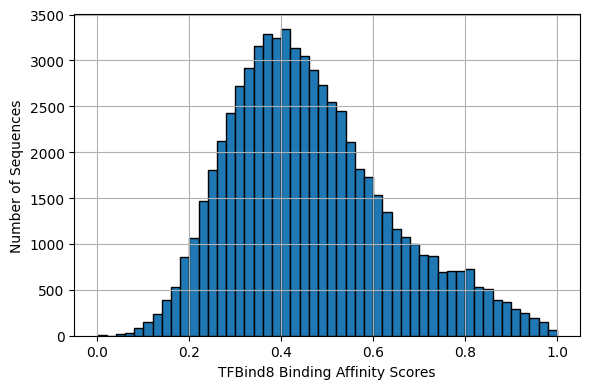

In [9]:
y_values = dataset.y.flatten()

def plot_y_values(y_values):
    # Plot the histogram of y values
    plt.figure(figsize=(6, 4))
    plt.hist(y_values, bins=50, edgecolor='black')
    plt.xlabel("TFBind8 Binding Affinity Scores")
    plt.ylabel("Number of Sequences")
    #plt.title("Distribution of Binding Scores (dataset.y)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_y_values(y_values)

In [10]:
sequence_tuples = [tuple(seq) for seq in dataset.x]
seq_counts = Counter(sequence_tuples)
num_occurring_twice = sum(1 for count in seq_counts.values() if count == 2)

print(f"Number of sequences occurring exactly 2 times (will be removed): {num_occurring_twice}")

Number of sequences occurring exactly 2 times (will be removed): 256


C:\Users\kroep\AppData\Local\Temp\ipykernel_11780\3643172498.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


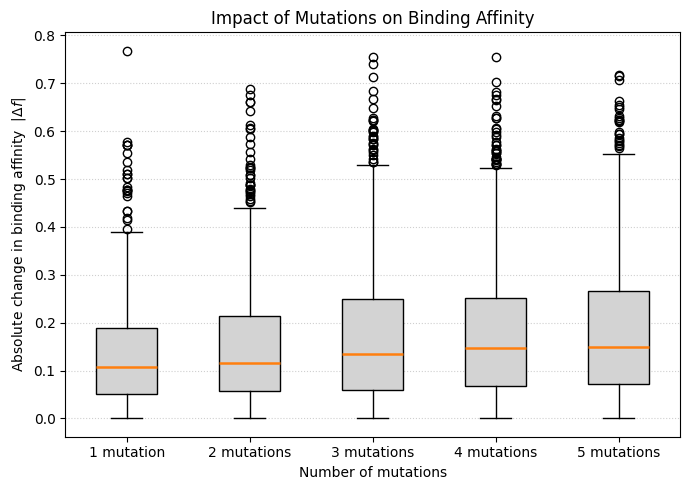

In [11]:
def mutate_sequence(seq, num_mutations=1, n_samples=25):
    seq = np.array(seq)
    mutated_seqs = []
    positions = list(range(len(seq)))

    for _ in range(n_samples):
        pos_to_mutate = random.sample(positions, num_mutations)
        mutated = seq.copy()
        for pos in pos_to_mutate:
            original_base = seq[pos]
            possible_bases = [b for b in range(4) if b != original_base]
            mutated[pos] = random.choice(possible_bases)
        mutated_seqs.append(mutated)
    
    return mutated_seqs

def compute_mutation_effects(dataset_x, dataset_y, mutation_counts=[1, 2, 3, 4, 5], n_sequences=50, seed=42):
    random.seed(seed)
    np.random.seed(seed)

    results = defaultdict(list)
    indices = np.random.choice(len(dataset_x), n_sequences, replace=False)

    for idx in indices:
        original_seq = dataset_x[idx]
        original_f = dataset_y[idx][0]  # y is shape (N,1)

        for n_mut in mutation_counts:
            mutated_variants = mutate_sequence(original_seq, num_mutations=n_mut)
            for var in mutated_variants:
                matches = np.all(dataset_x == var, axis=1)
                if np.any(matches):
                    mutated_f = dataset_y[matches][0][0]
                    delta_f = abs(original_f - mutated_f)
                    results[n_mut].append(delta_f)
    
    return results


mutation_effects = compute_mutation_effects(dataset.x, dataset.y)
mutation_labels = [f"{n} mutation" if n == 1 else f"{n} mutations" for n in [1, 2, 3, 4, 5]]

plt.figure(figsize=(7, 5))
box = plt.boxplot(
    [mutation_effects[n] for n in [1, 2, 3, 4, 5]],
    labels=mutation_labels,
    patch_artist=True,
    medianprops=dict(color="#ff7f0e", linewidth=1.8),
)

for patch in box["boxes"]:
    patch.set(facecolor="lightgray", edgecolor="black", linewidth=1)

plt.ylabel(r"Absolute change in binding affinity  $|\Delta f|$")
plt.xlabel("Number of mutations")
plt.title("Impact of Mutations on Binding Affinity")
plt.grid(axis="y", linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()

## Dataset Split

**Notes:**
- Take a random sequence in the dataset and get all mutations up to 6. That data is then split into training and validation sets.
- For testing we want to create an Out-Of-Distribution Dataset, which is the remaining data, so 7 and 8 mutations in this case.

In [12]:
# only select unique occurences
x_data, unique_indices = np.unique(dataset.x, axis=0, return_index=True)
y_data = dataset.y[unique_indices]

In [13]:
len(dataset.x) == len(x_data) + num_occurring_twice

True

In [14]:
# select a random anchor for the mutation dataset
np.random.seed(42)
anchor_idx = np.random.choice(len(x_data))
anchor_seq = x_data[anchor_idx]

print(f'anchor_seq: {anchor_seq.tolist()}')

anchor_seq: [3, 1, 3, 0, 1, 2, 1, 2]


In [15]:
# select a random anchor for the mutation dataset
np.random.seed(42)
anchor_idx = np.random.choice(len(x_data))
anchor_seq = x_data[anchor_idx]

# hamming distances for randomly selected anchorr
mutation_distances = np.array([np.sum(seq != anchor_seq) for seq in x_data])

# create mutation set (1–5 mutations away from anchor)
mutation_mask = (mutation_distances >= 1) & (mutation_distances <= 6)
x_max_6_mutations = x_data[mutation_mask]
y_max_6_mutations = y_data[mutation_mask]

x_train, x_temp, y_train, y_temp = train_test_split(x_max_6_mutations, y_max_6_mutations, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

(len(x_data), len(x_max_6_mutations), len(x_train), len(x_val), len(x_test))

(65536, 41478, 33182, 4148, 4148)

In [16]:
mutation_mask = (mutation_distances == 7)
x_7_mutations = x_data[mutation_mask]
y_7_mutations = y_data[mutation_mask]

mutation_mask = (mutation_distances == 8)
x_8_mutations = x_data[mutation_mask]
y_8_mutations = y_data[mutation_mask]

len(x_data) - 1 == len(x_max_6_mutations) + len(x_7_mutations) + len(x_8_mutations)

True

In [17]:
len(x_data)

65536

In [18]:
# # get remaining data and make the dataset split
# remaining_mask = ~mutation_mask
# x_geq_6_mutations = x_data[remaining_mask]
# y_geq_6_remaining = y_data[remaining_mask]
# len(x_geq_6_mutations)

# len(x_train)+len(x_val)+len(x_test) == len(x_max_6_mutations)

## Train RF Baseline

In [19]:
rf_results = list()

for i in range(10):
    results_safe = []

    best_mae = float("inf")
    rf_scorer = None
    
    n_trees = 1501 # just some large number
    # for n_trees in tree_counts_safe:
    rf = RandomForestRegressor(n_estimators=n_trees, random_state=42+i, n_jobs=1)
    rf.fit(x_train, y_train.ravel())

    y_pred_rf = rf.predict(x_val)
    mae_rf = mean_absolute_error(y_val, y_pred_rf)
    results_safe.append((n_trees, mae_rf))

    if mae_rf < best_mae:
        best_mae = mae_rf
        rf_scorer = rf

    y_pred_test = rf_scorer.predict(x_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    error_std_test = np.std(np.abs(y_pred_test - y_test))

    y_pred_7_mutations = rf_scorer.predict(x_7_mutations)
    mae_7_mutations = mean_absolute_error(y_7_mutations, y_pred_7_mutations)
    error_std_7_mutations = np.std(np.abs(y_pred_7_mutations - y_7_mutations))

    y_pred_8_mutations = rf_scorer.predict(x_8_mutations)
    mae_8_mutations = mean_absolute_error(y_8_mutations, y_pred_8_mutations)
    error_std_8_mutations = np.std(np.abs(y_pred_8_mutations - y_8_mutations))
    
    rf_results.append({
        'model': 'rf',
        'model_num': i,
        'test_mae': float(mae_test),
        'test_std': float(error_std_test),
        'test_se': float(error_std_test / np.sqrt(len(y_test))),
        'ood_7_mut_mae': float(mae_7_mutations),
        'ood_7_mut_std': float(error_std_7_mutations),
        'ood_7_mut_se': float(error_std_7_mutations / np.sqrt(len(y_7_mutations))),
        'ood_8_mut_mae': float(mae_8_mutations),
        'ood_8_mut_std': float(error_std_8_mutations),
        'ood_8_mut_se': float(error_std_8_mutations / np.sqrt(len(y_8_mutations)))
    })

# df_results = pd.DataFrame(results_safe, columns=["n_trees", "MAE"])
# df_results

In [20]:
rf_results

[{'model': 'rf',
  'model_num': 0,
  'test_mae': 0.08194366813005582,
  'test_std': 0.14004719034085755,
  'test_se': 0.002174478041891739,
  'ood_7_mut_mae': 0.09126189722615821,
  'ood_7_mut_std': 0.13963567786047146,
  'ood_7_mut_se': 0.00105566716248704,
  'ood_8_mut_mae': 0.10810901484043046,
  'ood_8_mut_std': 0.13778548136479124,
  'ood_8_mut_se': 0.00170105532549125},
 {'model': 'rf',
  'model_num': 1,
  'test_mae': 0.08184451907825628,
  'test_std': 0.14024029943877428,
  'test_se': 0.002177476399031839,
  'ood_7_mut_mae': 0.09183333422734566,
  'ood_7_mut_std': 0.13904274409765177,
  'ood_7_mut_se': 0.001051184492208717,
  'ood_8_mut_mae': 0.10965404618936585,
  'ood_8_mut_std': 0.13718895846170218,
  'ood_8_mut_se': 0.0016936908452061996},
 {'model': 'rf',
  'model_num': 2,
  'test_mae': 0.08211359887622098,
  'test_std': 0.13984937143685033,
  'test_se': 0.0021714065567588503,
  'ood_7_mut_mae': 0.09160550555025211,
  'ood_7_mut_std': 0.13938786535791364,
  'ood_7_mut_se': 

In [21]:
df_rf_perf = pd.DataFrame(rf_results)
df_rf_perf

model  model_num  test_mae  test_std   test_se  ood_7_mut_mae  \
0    rf          0  0.081944  0.140047  0.002174       0.091262   
1    rf          1  0.081845  0.140240  0.002177       0.091833   
2    rf          2  0.082114  0.139849  0.002171       0.091606   
3    rf          3  0.081598  0.140239  0.002177       0.091756   
4    rf          4  0.081621  0.139926  0.002173       0.091158   
5    rf          5  0.080979  0.140042  0.002174       0.091663   
6    rf          6  0.082259  0.140067  0.002175       0.091710   
7    rf          7  0.081432  0.140082  0.002175       0.091779   
8    rf          8  0.081231  0.140313  0.002179       0.091510   
9    rf          9  0.081637  0.139906  0.002172       0.091540   

   ood_7_mut_std  ood_7_mut_se  ood_8_mut_mae  ood_8_mut_std  ood_8_mut_se  
0       0.139636      0.001056       0.108109       0.137785      0.001701  
1       0.139043      0.001051       0.109654       0.137189      0.001694  
2       0.139388      0.001054       0.108638       0.136933      0.001691  
3       0.139510      0.001055       0.109503       0.138609      0.001711  
4       0.139289      0.001053       0.108297       0.136760      0.001688  
5       0.139161      0.001052       0.108292       0.137937      0.001703  
6       0.139370      0.001054       0.109088       0.137520      0.001698  
7       0.139236      0.001053       0.109251       0.137204      0.001694  
8       0.139497      0.001055       0.108472       0.137643      0.001699  
9       0.139143      0.001052       0.108223       0.136980      0.001691

In [22]:
'''plt.figure(figsize=(8, 5))
plt.plot(df_results["n_trees"], df_results["MAE"], marker='o')
plt.xlabel("n_trees")
plt.ylabel("MAE")
plt.title("RandomForest performance for different number of trees")
plt.grid(True)
plt.show()'''

'plt.figure(figsize=(8, 5))\nplt.plot(df_results["n_trees"], df_results["MAE"], marker=\'o\')\nplt.xlabel("n_trees")\nplt.ylabel("MAE")\nplt.title("RandomForest performance for different number of trees")\nplt.grid(True)\nplt.show()'

In [23]:
'''y_pred_test = rf_scorer.predict(x_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
error_std_test = np.std(np.abs(y_pred_test - y_test))

y_pred_7_mutations = rf_scorer.predict(x_7_mutations)
mae_7_mutations = mean_absolute_error(y_7_mutations, y_pred_7_mutations)
error_std_7_mutations = np.std(np.abs(y_pred_7_mutations - y_7_mutations))

y_pred_8_mutations = rf_scorer.predict(x_8_mutations)
mae_8_mutations = mean_absolute_error(y_8_mutations, y_pred_8_mutations)
error_std_8_mutations = np.std(np.abs(y_pred_8_mutations - y_8_mutations))'''

'y_pred_test = rf_scorer.predict(x_test)\nmae_test = mean_absolute_error(y_test, y_pred_test)\nerror_std_test = np.std(np.abs(y_pred_test - y_test))\n\ny_pred_7_mutations = rf_scorer.predict(x_7_mutations)\nmae_7_mutations = mean_absolute_error(y_7_mutations, y_pred_7_mutations)\nerror_std_7_mutations = np.std(np.abs(y_pred_7_mutations - y_7_mutations))\n\ny_pred_8_mutations = rf_scorer.predict(x_8_mutations)\nmae_8_mutations = mean_absolute_error(y_8_mutations, y_pred_8_mutations)\nerror_std_8_mutations = np.std(np.abs(y_pred_8_mutations - y_8_mutations))'

## Hyperparameter Search

In [24]:
shared_training_config = {
    "epochs": 400,
    "eval_every": 5,
    "early_stopping_patience": 20
}

with open('search_spaces/shared_training_config.json', 'w') as f:
    json.dump(shared_training_config, f, indent=3)

#### Best settings

In [25]:
mlp_search_space = {
  "model": {
    "hidden_dims": [256],
    "num_layers": [3],
    "dropout_input": [0.0],
    "dropout_hidden": [0.3]
  },
  "training": {
    "batch_size": [32],
    "learning_rate": [0.0005],
    "weight_decay": [0.001],
    "loss": ["mse"]
  }
}

cnn_search_space = {
  "model": {
    "channels": [
          [32, 64, 128]
        ],
        "kernel_size": [5],
        "fc_dim": [128],
        "dropout_input": [0.0],
        "dropout_hidden": [0.3]
  },
  "training": {
    "batch_size": [32],
    "learning_rate": [0.0005],
    "weight_decay": [0.001],
    "loss": ["mse"]
  }
}


lstm_search_space = {
  "model": {
    "hidden_dim": [64],
    "num_layers": [2],
    "dropout_input": [0.2],
    "dropout_hidden": [0.5],
    "fc_dim": [128],
    "bidirectional": [True]
  },
  "training": {
    "batch_size": [128],
    "learning_rate": [0.001],
    "weight_decay": [0.0],
    "loss": ["mse"]
  }
}

lstm_cnn_search_space = {
  "model": {
    "lstm_hidden_dim": [32],
    "lstm_layers": [2],
    "dropout_input": [0.0],
    "dropout_hidden": [0.3],
    "bidirectional": [False],
    "cnn_channels": [
      [32, 64, 128]
    ],
    "kernel_size": [7],
    "fc_dim": [96]
  },
  "training": {
    "batch_size": [32],
    "learning_rate": [0.0005],
    "weight_decay": [0.001],
    "loss": ["mse"]
  }
}

cnn_lstm_search_space = {
  "model": {
    "lstm_hidden_dim": [256],
    "lstm_layers": [2],
    "dropout_input": [0.0],
    "dropout_hidden": [0.3],
    "bidirectional": [False],
    "cnn_channels": [
      [64, 128]
    ],
    "kernel_size": [5],
    "fc_dim": [96]
  },
  "training": {
    "batch_size": [32],
    "learning_rate": [0.0005],
    "weight_decay": [0.001],
    "loss": ["mse"]
  }
}

transformer_search_space = {
  "model": {
    "seq_len": [8],
    "d_model": [32],
    "nhead": [2],
    "num_layers": [2],
    "dim_feedforward": [512],
    "dropout_input": [0.0],
    "dropout_hidden": [0.2]
  },
  "training": {
    "batch_size": [32],
    "learning_rate": [0.001],
    "weight_decay": [0.0001],
    "loss": ["mse"]
  }
}

#### Other settings

In [26]:
'''training = {
    "batch_size": [32, 64, 128],
    "learning_rate": [0.001, 0.0005],
    "weight_decay": [0.0, 0.01],
    "loss": ["mae", "mse"]
}'''

training = {
    "batch_size": [32, 64, 128],
    "learning_rate": [0.001, 0.0005],
    "weight_decay": [0.0, 0.01, 0.001, 0.0001],
    "loss": ["mae", "mse"]
}

In [27]:
'''mlp_search_space = {
  "model": {
    "hidden_dims": [32, 64, 128],
    "num_layers": [2, 3, 4],
    "dropout_input": [0.1, 0.2],
    "dropout_hidden": [0.5, 0.6, 0.7]
  },
  "training": training
}

with open('search_spaces/mlp_search_space.json', 'w') as f:
    json.dump(mlp_search_space, f, indent=2)'''

'''
mlp_search_space = {
  "model": {
    "hidden_dims": [32, 48, 64],
    "num_layers": [2, 3],
    "dropout_input": [0.15, 0.2],
    "dropout_hidden": [0.4, 0.5, 0.6]
  },
  "training": training
}
'''

'''mlp_search_space = {
  "model": {
    "hidden_dims": [32, 64, 128, 256],
    "num_layers": [2, 3, 4],
    "dropout_input": [0.0, 0.1, 0.2, 0.3],
    "dropout_hidden": [0.3, 0.4, 0.5, 0.6, 0.7]
  },
  "training": training
}'''

with open('search_spaces/mlp_search_space.json', 'w') as f:
    json.dump(mlp_search_space, f, indent=2)

In [28]:
'''cnn_search_space = {
  "model": {
    "dropout_input": [0.1, 0.2],
    "dropout_hidden": [0.5, 0.6, 0.7],
    "channels": [[32, 64], [64, 128]],
    "kernel_size": [3, 5],
    "fc_dim": [32, 64, 128]
  },
  "training": training
}

with open('search_spaces/cnn_search_space.json', 'w') as f:
    json.dump(cnn_search_space, f, indent=2)'''

'''cnn_search_space = {
  "model": {
    "channels": [[32, 64], [48, 96]],
    "kernel_size": [3],
    "fc_dim": [64, 96],
    "dropout_input": [0.1, 0.15, 0.2],
    "dropout_hidden": [0.4, 0.5, 0.6]
  },
  "training": training
}'''

'''cnn_search_space = {
  "model": {
    "channels": [
          [32, 64],
          [48, 96],
          [64, 128],
          [32, 64, 128],
          [48, 96, 192]
        ],
        # cover pointwise to wide context (seq_len=8)
        "kernel_size": [1, 3, 5, 7],
        # widen FC head capacity
        "fc_dim": [64, 96, 128, 192, 256],
        # regularization sweep
        "dropout_input": [0.0, 0.1, 0.15, 0.2, 0.3],
        "dropout_hidden": [0.3, 0.4, 0.5, 0.6, 0.7]
  },
  "training": training
}'''

with open('search_spaces/cnn_search_space.json', 'w') as f:
    json.dump(cnn_search_space, f, indent=2)

In [29]:
'''lstm_search_space = {
  "model": {
    "hidden_dim": [32, 64, 128],
    "num_layers": [1, 2, 3],
    "dropout_input": [0.1, 0.2],
    "dropout_hidden": [0.5, 0.6, 0.7],
    "fc_dim": [64, 128, 256],
    "bidirectional": [True, False]
  },
  "training": training
}

with open('search_spaces/lstm_search_space.json', 'w') as f:
    json.dump(lstm_search_space, f, indent=2)'''

'''
lstm_search_space = {
  "model": {
    "hidden_dim": [32, 64],
    "num_layers": [1, 2],
    "dropout_input": [0.1, 0.2],
    "dropout_hidden": [0.5, 0.6],
    "fc_dim": [64, 128],
    "bidirectional": [True]
  },
  "training": training
}
'''

'''lstm_search_space = {
  "model": {
    "hidden_dim": [32, 64, 128, 192, 256],
    "num_layers": [1, 2, 3],
    "dropout_input": [0.0, 0.1, 0.2, 0.3],
    "dropout_hidden": [0.3, 0.4, 0.5, 0.6, 0.7],
    "fc_dim": [64, 96, 128, 192, 256],
    "bidirectional": [True, False]
  },
  "training": training
}'''

with open('search_spaces/lstm_search_space.json', 'w') as f:
    json.dump(lstm_search_space, f, indent=2)

In [30]:
'''lstm_cnn_search_space = {
  "model": {
    "lstm_hidden_dim": [32, 64],
    "lstm_layers": [1, 2],
    "dropout_input": [0.1, 0.2],
    "dropout_hidden": [0.5, 0.6, 0.7],
    "bidirectional": [True, False],
    "cnn_channels": [[32, 64], [64, 128]],
    "kernel_size": [3, 5],
    "fc_dim": [32, 64]
  },
  "training": training
}

with open('search_spaces/lstm_cnn_search_space.json', 'w') as f:
    json.dump(lstm_cnn_search_space, f, indent=2)'''

'''lstm_cnn_search_space = {
  "model": {
    "lstm_hidden_dim": [32, 64],
    "lstm_layers": [1],
    "dropout_input": [0.1, 0.2],
    "dropout_hidden": [0.5, 0.6],
    "cnn_channels": [[32, 64], [48, 96]],
    "kernel_size": [3],
    "fc_dim": [32, 64],
    "bidirectional": [True, False]
  },
  "training": training
}'''

'''lstm_cnn_search_space = {
  "model": {
    "lstm_hidden_dim": [32, 64, 128, 192, 256],
    "lstm_layers": [1, 2, 3],
    "dropout_input": [0.0, 0.1, 0.2, 0.3],
    "dropout_hidden": [0.3, 0.4, 0.5, 0.6, 0.7],
    "bidirectional": [True, False],
    "cnn_channels": [
      [32, 64],
      [48, 96],
      [64, 128],
      [32, 64, 128],
      [48, 96, 192]
    ],
    "kernel_size": [1, 3, 5, 7],
    "fc_dim": [64, 96, 128, 192, 256]
  },
  "training": training
}'''

with open('search_spaces/lstm_cnn_search_space.json', 'w') as f:
    json.dump(lstm_cnn_search_space, f, indent=2)

In [31]:
'''cnn_lstm_search_space = {
  "model": {
    "lstm_hidden_dim": [32, 64],
    "lstm_layers": [1, 2],
    "dropout_input": [0.1, 0.2],
    "dropout_hidden": [0.5, 0.6, 0.7],
    "bidirectional": [True, False],
    "cnn_channels": [[32, 64], [64, 128]],
    "kernel_size": [3, 5],
    "fc_dim": [32, 64]
  },
  "training": training
}

with open('search_spaces/cnn_lstm_search_space.json', 'w') as f:
    json.dump(cnn_lstm_search_space, f, indent=2)'''

'''cnn_lstm_search_space = {
  "model": {
    "cnn_channels": [[32, 64]],
    "kernel_size": [3],
    "lstm_hidden_dim": [32],
    "lstm_layers": [1],
    "fc_dim": [32, 64],
    "dropout_input": [0.2],
    "dropout_hidden": [0.5, 0.6],
    "bidirectional": [True, False]
  },
  "training": training
}'''

'''cnn_lstm_search_space = {
  "model": {
    "lstm_hidden_dim": [32, 64, 128, 192, 256],
    "lstm_layers": [1, 2, 3],
    "dropout_input": [0.0, 0.1, 0.2, 0.3],
    "dropout_hidden": [0.3, 0.4, 0.5, 0.6, 0.7],
    "bidirectional": [True, False],
    "cnn_channels": [
      [32, 64],
      [48, 96],
      [64, 128],
      [32, 64, 128],
      [48, 96, 192]
    ],
    "kernel_size": [1, 3, 5, 7],
    "fc_dim": [64, 96, 128, 192, 256]
  },
  "training": training
}'''

with open('search_spaces/cnn_lstm_search_space.json', 'w') as f:
    json.dump(cnn_lstm_search_space, f, indent=2)

In [32]:
'''transformer_search_space = {
  "model": {
    "seq_len": [8],
    "d_model": [32, 64, 128],
    "nhead": [2, 4, 8],
    "num_layers": [1, 2, 3],
    "dim_feedforward": [64, 128, 256],
    "dropout_input": [0.1, 0.2],
    "dropout_hidden": [0.5, 0.6, 0.7]
  },
  "training": training
}

with open('search_spaces/transformer_search_space.json', 'w') as f:
    json.dump(transformer_search_space, f, indent=2)'''

'''transformer_search_space = {
  "model": {
    "seq_len": [8],
    "d_model": [48, 64],
    "nhead": [2, 4],
    "num_layers": [1, 2],
    "dim_feedforward": [128],
    "dropout_input": [0.2],
    "dropout_hidden": [0.5, 0.6]
  },
  "training": training
}'''

'''transformer_search_space = {
  "model": {
    "seq_len": [8],
    "d_model": [32, 48, 64, 96, 128],
    "nhead": [2, 4, 8],
    "num_layers": [1, 2, 3],
    "dim_feedforward": [128, 256, 384, 512],
    "dropout_input": [0.0, 0.1, 0.2, 0.3],
    "dropout_hidden": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
  },
  "training": training
}'''

with open('search_spaces/transformer_search_space.json', 'w') as f:
    json.dump(transformer_search_space, f, indent=2)

### Random Search

In [33]:
from ps_functions.random_search import random_search

train_fns = {
    "mlp": train_mlp_from_config,
    "cnn": train_cnn_from_config,
    "lstm": train_lstm_from_config,
    "lstm_cnn": train_lstm_cnn_from_config,
    "cnn_lstm": train_cnn_lstm_from_config,
    "transformer": train_transformer_from_config
}

search_paths = {
    "mlp": "search_spaces/mlp_search_space.json",
    "cnn": "search_spaces/cnn_search_space.json",
    "lstm": "search_spaces/lstm_search_space.json",
    "lstm_cnn": "search_spaces/lstm_cnn_search_space.json",
    "cnn_lstm": "search_spaces/cnn_lstm_search_space.json",
    "transformer": "search_spaces/transformer_search_space.json"
}

'''rs_hyperparameter_folder = str(random_search(
    train_fns, search_paths, x_train, y_train, x_val, y_val, n_trials=10, evaluation=True))'''

'rs_hyperparameter_folder = str(random_search(\n    train_fns, search_paths, x_train, y_train, x_val, y_val, n_trials=10, evaluation=True))'

## Evaluate Models

#### Take the average over 10 runs per best hyperparameter setting

In [34]:
'''
rs_hyperparameter_folders = [
    'results\\training\\random_search_2025-07-20-00-31',
    'results\\training\\random_search_2025-07-25-00-05',
    'results\\training\\random_search_2025-09-27-21-41',
    'results\\training\\random_search_2025-09-30-21-49',
    'results\\training\\random_search_2025-10-02-08-04'
]
'''

# rs_hyperparameter_folders = ['results\\evaluation\\evaluation_top_config_3_times_2025-11-05-13-36']

rs_hyperparameter_folders = [
    'results\\evaluation\\evaluation_top_config_10_times_2025-11-05-16-01']

In [35]:
def load_runs(folder):
    df_results = pd.read_csv(f'{(folder)}\\configurations.csv')
    df_summary= pd.read_csv(f'{(folder)}\\summary.csv')
    df_results['best_mae'] = df_summary['best_mae']
    df_results['val_error_std'] = df_summary['val_error_std']
    return df_results

In [36]:
def load_folders(folder_list):
    dfs = []
    for folder in folder_list:
        df = load_runs(folder)
        df['folder'] = folder
        df['run_name'] = os.path.basename(folder)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

df_loaded = load_folders(rs_hyperparameter_folders)

df_loaded[df_loaded.best_mae<0.07][
    ['model_class', 'trial', 'best_mae', 'val_error_std', 'folder']].model_class.value_counts().to_dict()

{'lstm': 10, 'cnn_lstm': 10, 'lstm_cnn': 8}

In [37]:
print(f'Completed {len(df_loaded)} random search runs.')

Completed 60 random search runs.


In [38]:
df_loaded[df_loaded.best_mae<0.07][
    ['model_class', 'trial', 'best_mae', 'val_error_std', 'folder']].model_class.value_counts().to_dict()

{'lstm': 10, 'cnn_lstm': 10, 'lstm_cnn': 8}

In [39]:
results = df_rf_perf.to_dict('records')

for model_class in df_loaded.model_class.unique():
    
    best_idx = int(df_loaded[df_loaded.model_class==model_class].best_mae.idxmin())
    best_row = df_loaded.iloc[best_idx]
    best_rs_hyperparameter_folder = best_row.folder
    
    print(best_rs_hyperparameter_folder)
    
    results += run_evaluation(
        folder=best_rs_hyperparameter_folder,
        model_names=[model_class],
        x_test=x_test,
        y_test=y_test,
        x_ood_7=x_7_mutations,
        y_ood_7=y_7_mutations,
        x_ood_8=x_8_mutations,
        y_ood_8=y_8_mutations,
        final_evaluation=True
    )

results\evaluation\evaluation_top_config_10_times_2025-11-05-16-01
Evaluating mlp: mlp



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\kroep\anaconda3\envs\ps_msc\Lib\runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\kroep\anaconda3\envs\ps_msc\Lib\runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "C:\Users\kroep\anaconda3\envs\ps_msc\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\kroep\anaconda3\envs\ps_msc\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start

mlp #0: Test MAE = 0.0754 (SD 0.1354, SE 0.0021); OOD7 MAE = 0.0962 (SD 0.1346, SE 0.0010); OOD8 MAE = 0.1221 (SD 0.1387, SE 0.0017)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

mlp #1: Test MAE = 0.0750 (SD 0.1355, SE 0.0021); OOD7 MAE = 0.0950 (SD 0.1347, SE 0.0010); OOD8 MAE = 0.1229 (SD 0.1388, SE 0.0017)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

mlp #2: Test MAE = 0.0751 (SD 0.1349, SE 0.0021); OOD7 MAE = 0.0946 (SD 0.1349, SE 0.0010); OOD8 MAE = 0.1211 (SD 0.1382, SE 0.0017)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

mlp #3: Test MAE = 0.0750 (SD 0.1354, SE 0.0021); OOD7 MAE = 0.0962 (SD 0.1344, SE 0.0010); OOD8 MAE = 0.1260 (SD 0.1386, SE 0.0017)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

mlp #4: Test MAE = 0.0759 (SD 0.1343, SE 0.0021); OOD7 MAE = 0.0948 (SD 0.1340, SE 0.0010); OOD8 MAE = 0.1197 (SD 0.1379, SE 0.0017)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

mlp #5: Test MAE = 0.0752 (SD 0.1354, SE 0.0021); OOD7 MAE = 0.0963 (SD 0.1347, SE 0.0010); OOD8 MAE = 0.1222 (SD 0.1379, SE 0.0017)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

mlp #6: Test MAE = 0.0770 (SD 0.1337, SE 0.0021); OOD7 MAE = 0.0970 (SD 0.1341, SE 0.0010); OOD8 MAE = 0.1248 (SD 0.1389, SE 0.0017)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

mlp #7: Test MAE = 0.0748 (SD 0.1353, SE 0.0021); OOD7 MAE = 0.0951 (SD 0.1343, SE 0.0010); OOD8 MAE = 0.1209 (SD 0.1365, SE 0.0017)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

mlp #8: Test MAE = 0.0745 (SD 0.1358, SE 0.0021); OOD7 MAE = 0.0958 (SD 0.1347, SE 0.0010); OOD8 MAE = 0.1223 (SD 0.1382, SE 0.0017)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

mlp #9: Test MAE = 0.0750 (SD 0.1347, SE 0.0021); OOD7 MAE = 0.0965 (SD 0.1342, SE 0.0010); OOD8 MAE = 0.1235 (SD 0.1375, SE 0.0017)
results\evaluation\evaluation_top_config_10_times_2025-11-05-16-01
Evaluating cnn: cnn
cnn #0: Test MAE = 0.0883 (SD 0.1322, SE 0.0021); OOD7 MAE = 0.0921 (SD 0.1371, SE 0.0010); OOD8 MAE = 0.0970 (SD 0.1429, SE 0.0018)
cnn #1: Test MAE = 0.0818 (SD 0.1338, SE 0.0021); OOD7 MAE = 0.0844 (SD 0.1384, SE 0.0010); OOD8 MAE = 0.0878 (SD 0.1443, SE 0.0018)
cnn #2: Test MAE = 0.0821 (SD 0.1333, SE 0.0021); OOD7 MAE = 0.0846 (SD 0.1380, SE 0.0010); OOD8 MAE = 0.0883 (SD 0.1441, SE 0.0018)
cnn #3: Test MAE = 0.0795 (SD 0.1346, SE 0.0021); OOD7 MAE = 0.0819 (SD 0.1395, SE 0.0011); OOD8 MAE = 0.0859 (SD 0.1449, SE 0.0018)
cnn #4: Test MAE = 0.0785 (SD 0.1363, SE 0.0021); OOD7 MAE = 0.0810 (SD 0.1406, SE 0.0011); OOD8 MAE = 0.0843 (SD 0.1461, SE 0.0018)
cnn #5: Test MAE = 0.0785 (SD 0.1353, SE 0.0021); OOD7 MAE = 0.0804 (SD 0.1399, SE 0.0011); OOD8 MAE = 0.0834 (SD 0

C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

lstm #0: Test MAE = 0.0681 (SD 0.1416, SE 0.0022); OOD7 MAE = 0.0687 (SD 0.1459, SE 0.0011); OOD8 MAE = 0.0732 (SD 0.1464, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

lstm #1: Test MAE = 0.0681 (SD 0.1425, SE 0.0022); OOD7 MAE = 0.0689 (SD 0.1465, SE 0.0011); OOD8 MAE = 0.0737 (SD 0.1467, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

lstm #2: Test MAE = 0.0680 (SD 0.1428, SE 0.0022); OOD7 MAE = 0.0689 (SD 0.1472, SE 0.0011); OOD8 MAE = 0.0726 (SD 0.1491, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

lstm #3: Test MAE = 0.0682 (SD 0.1426, SE 0.0022); OOD7 MAE = 0.0688 (SD 0.1468, SE 0.0011); OOD8 MAE = 0.0732 (SD 0.1467, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

lstm #4: Test MAE = 0.0679 (SD 0.1421, SE 0.0022); OOD7 MAE = 0.0690 (SD 0.1462, SE 0.0011); OOD8 MAE = 0.0731 (SD 0.1467, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

lstm #5: Test MAE = 0.0681 (SD 0.1433, SE 0.0022); OOD7 MAE = 0.0687 (SD 0.1481, SE 0.0011); OOD8 MAE = 0.0719 (SD 0.1499, SE 0.0019)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

lstm #6: Test MAE = 0.0676 (SD 0.1420, SE 0.0022); OOD7 MAE = 0.0681 (SD 0.1456, SE 0.0011); OOD8 MAE = 0.0711 (SD 0.1469, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

lstm #7: Test MAE = 0.0678 (SD 0.1430, SE 0.0022); OOD7 MAE = 0.0687 (SD 0.1471, SE 0.0011); OOD8 MAE = 0.0715 (SD 0.1484, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

lstm #8: Test MAE = 0.0678 (SD 0.1425, SE 0.0022); OOD7 MAE = 0.0688 (SD 0.1459, SE 0.0011); OOD8 MAE = 0.0729 (SD 0.1460, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

lstm #9: Test MAE = 0.0678 (SD 0.1409, SE 0.0022); OOD7 MAE = 0.0694 (SD 0.1438, SE 0.0011); OOD8 MAE = 0.0742 (SD 0.1443, SE 0.0018)
results\evaluation\evaluation_top_config_10_times_2025-11-05-16-01
Evaluating lstm_cnn: lstm_cnn


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

lstm_cnn #0: Test MAE = 0.0693 (SD 0.1377, SE 0.0021); OOD7 MAE = 0.0739 (SD 0.1397, SE 0.0011); OOD8 MAE = 0.0879 (SD 0.1420, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

lstm_cnn #1: Test MAE = 0.0705 (SD 0.1360, SE 0.0021); OOD7 MAE = 0.0771 (SD 0.1380, SE 0.0010); OOD8 MAE = 0.0925 (SD 0.1407, SE 0.0017)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

lstm_cnn #2: Test MAE = 0.0694 (SD 0.1380, SE 0.0021); OOD7 MAE = 0.0737 (SD 0.1410, SE 0.0011); OOD8 MAE = 0.0856 (SD 0.1439, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

lstm_cnn #3: Test MAE = 0.0689 (SD 0.1390, SE 0.0022); OOD7 MAE = 0.0756 (SD 0.1404, SE 0.0011); OOD8 MAE = 0.0900 (SD 0.1417, SE 0.0017)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

lstm_cnn #4: Test MAE = 0.0690 (SD 0.1398, SE 0.0022); OOD7 MAE = 0.0746 (SD 0.1418, SE 0.0011); OOD8 MAE = 0.0912 (SD 0.1425, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

lstm_cnn #5: Test MAE = 0.0690 (SD 0.1385, SE 0.0022); OOD7 MAE = 0.0746 (SD 0.1411, SE 0.0011); OOD8 MAE = 0.0871 (SD 0.1428, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

lstm_cnn #6: Test MAE = 0.0685 (SD 0.1385, SE 0.0021); OOD7 MAE = 0.0733 (SD 0.1409, SE 0.0011); OOD8 MAE = 0.0847 (SD 0.1444, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

lstm_cnn #7: Test MAE = 0.0689 (SD 0.1383, SE 0.0021); OOD7 MAE = 0.0734 (SD 0.1406, SE 0.0011); OOD8 MAE = 0.0850 (SD 0.1423, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

lstm_cnn #8: Test MAE = 0.0694 (SD 0.1378, SE 0.0021); OOD7 MAE = 0.0750 (SD 0.1398, SE 0.0011); OOD8 MAE = 0.0877 (SD 0.1415, SE 0.0017)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

lstm_cnn #9: Test MAE = 0.0691 (SD 0.1395, SE 0.0022); OOD7 MAE = 0.0731 (SD 0.1422, SE 0.0011); OOD8 MAE = 0.0868 (SD 0.1445, SE 0.0018)
results\evaluation\evaluation_top_config_10_times_2025-11-05-16-01
Evaluating cnn_lstm: cnn_lstm


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

cnn_lstm #0: Test MAE = 0.0677 (SD 0.1422, SE 0.0022); OOD7 MAE = 0.0734 (SD 0.1448, SE 0.0011); OOD8 MAE = 0.0906 (SD 0.1469, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

cnn_lstm #1: Test MAE = 0.0680 (SD 0.1427, SE 0.0022); OOD7 MAE = 0.0735 (SD 0.1452, SE 0.0011); OOD8 MAE = 0.0926 (SD 0.1468, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

cnn_lstm #2: Test MAE = 0.0679 (SD 0.1425, SE 0.0022); OOD7 MAE = 0.0730 (SD 0.1446, SE 0.0011); OOD8 MAE = 0.0894 (SD 0.1463, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

cnn_lstm #3: Test MAE = 0.0675 (SD 0.1423, SE 0.0022); OOD7 MAE = 0.0730 (SD 0.1446, SE 0.0011); OOD8 MAE = 0.0909 (SD 0.1457, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

cnn_lstm #4: Test MAE = 0.0674 (SD 0.1422, SE 0.0022); OOD7 MAE = 0.0727 (SD 0.1443, SE 0.0011); OOD8 MAE = 0.0881 (SD 0.1459, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

cnn_lstm #5: Test MAE = 0.0677 (SD 0.1424, SE 0.0022); OOD7 MAE = 0.0728 (SD 0.1444, SE 0.0011); OOD8 MAE = 0.0913 (SD 0.1458, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

cnn_lstm #6: Test MAE = 0.0681 (SD 0.1418, SE 0.0022); OOD7 MAE = 0.0757 (SD 0.1432, SE 0.0011); OOD8 MAE = 0.0971 (SD 0.1443, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

cnn_lstm #7: Test MAE = 0.0676 (SD 0.1422, SE 0.0022); OOD7 MAE = 0.0731 (SD 0.1445, SE 0.0011); OOD8 MAE = 0.0903 (SD 0.1452, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

cnn_lstm #8: Test MAE = 0.0678 (SD 0.1423, SE 0.0022); OOD7 MAE = 0.0736 (SD 0.1442, SE 0.0011); OOD8 MAE = 0.0927 (SD 0.1454, SE 0.0018)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

cnn_lstm #9: Test MAE = 0.0679 (SD 0.1422, SE 0.0022); OOD7 MAE = 0.0734 (SD 0.1438, SE 0.0011); OOD8 MAE = 0.0910 (SD 0.1446, SE 0.0018)
results\evaluation\evaluation_top_config_10_times_2025-11-05-16-01
Evaluating transformer: transformer


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

transformer #0: Test MAE = 0.0762 (SD 0.1424, SE 0.0022); OOD7 MAE = 0.0894 (SD 0.1396, SE 0.0011); OOD8 MAE = 0.1169 (SD 0.1392, SE 0.0017)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

transformer #1: Test MAE = 0.0755 (SD 0.1434, SE 0.0022); OOD7 MAE = 0.0879 (SD 0.1426, SE 0.0011); OOD8 MAE = 0.0948 (SD 0.1395, SE 0.0017)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

transformer #2: Test MAE = 0.0769 (SD 0.1456, SE 0.0023); OOD7 MAE = 0.0871 (SD 0.1427, SE 0.0011); OOD8 MAE = 0.1187 (SD 0.1355, SE 0.0017)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

transformer #3: Test MAE = 0.0766 (SD 0.1434, SE 0.0022); OOD7 MAE = 0.0850 (SD 0.1424, SE 0.0011); OOD8 MAE = 0.0937 (SD 0.1399, SE 0.0017)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

transformer #4: Test MAE = 0.0763 (SD 0.1429, SE 0.0022); OOD7 MAE = 0.0966 (SD 0.1384, SE 0.0010); OOD8 MAE = 0.1048 (SD 0.1411, SE 0.0017)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

transformer #5: Test MAE = 0.0774 (SD 0.1433, SE 0.0022); OOD7 MAE = 0.0905 (SD 0.1418, SE 0.0011); OOD8 MAE = 0.1276 (SD 0.1375, SE 0.0017)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

transformer #6: Test MAE = 0.0760 (SD 0.1425, SE 0.0022); OOD7 MAE = 0.0946 (SD 0.1374, SE 0.0010); OOD8 MAE = 0.1145 (SD 0.1348, SE 0.0017)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

transformer #7: Test MAE = 0.0771 (SD 0.1428, SE 0.0022); OOD7 MAE = 0.0900 (SD 0.1407, SE 0.0011); OOD8 MAE = 0.1168 (SD 0.1319, SE 0.0016)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

transformer #8: Test MAE = 0.0756 (SD 0.1433, SE 0.0022); OOD7 MAE = 0.0858 (SD 0.1414, SE 0.0011); OOD8 MAE = 0.0996 (SD 0.1394, SE 0.0017)


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=

transformer #9: Test MAE = 0.0768 (SD 0.1427, SE 0.0022); OOD7 MAE = 0.0852 (SD 0.1410, SE 0.0011); OOD8 MAE = 0.1062 (SD 0.1314, SE 0.0016)


In [40]:
df_results_raw = pd.read_csv('df_results_raw-2025-11-08.csv')

# number pattern: optional sign, int/float, optional exponent
num = r'[-+]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][-+]?\d+)?'
pat = re.compile(rf'tensor\(\s*({num})')

cols = [
    'test_mae','test_std','test_se',
    'ood_7_mut_mae','ood_7_mut_std','ood_7_mut_se',
    'ood_8_mut_mae','ood_8_mut_std','ood_8_mut_se'
]

for col in cols:
    s = df_results_raw[col].astype(str)
    extracted = s.str.extract(pat, expand=False)
    fallback = s.str.extract(rf'({num})', expand=False)
    df_results_raw[col] = pd.to_numeric(extracted.fillna(fallback), errors='coerce')

df_results_raw

model  model_num  test_mae  test_std   test_se  ood_7_mut_mae  \
0            rf          0  0.078900  0.139323  0.002163       0.088567   
1            rf          1  0.078985  0.139336  0.002163       0.088611   
2            rf          2  0.078910  0.139358  0.002164       0.088628   
3            rf          3  0.078884  0.139363  0.002164       0.088587   
4            rf          4  0.078965  0.139369  0.002164       0.088565   
..          ...        ...       ...       ...       ...            ...   
65  transformer          5  0.077430  0.143328  0.002200       0.090482   
66  transformer          6  0.076015  0.142519  0.002200       0.094575   
67  transformer          7  0.077124  0.142817  0.002200       0.090026   
68  transformer          8  0.075570  0.143309  0.002200       0.085845   
69  transformer          9  0.076845  0.142664  0.002200       0.085234   

    ood_7_mut_std  ood_7_mut_se  ood_8_mut_mae  ood_8_mut_std  ood_8_mut_se  
0        0.138423      0.001046       0.105527       0.136205      0.001682  
1        0.138454      0.001047       0.105496       0.136369      0.001684  
2        0.138360      0.001046       0.105519       0.136164      0.001681  
3        0.138466      0.001047       0.105506       0.136355      0.001683  
4        0.138365      0.001046       0.105618       0.136123      0.001681  
..            ...           ...            ...            ...           ...  
65       0.141791      0.001100       0.127622       0.137540      0.001700  
66       0.137377      0.001000       0.114528       0.134790      0.001700  
67       0.140706      0.001100       0.116774       0.131946      0.001600  
68       0.141354      0.001100       0.099575       0.139400      0.001700  
69       0.141030      0.001100       0.106208       0.131398      0.001600  

[70 rows x 11 columns]

In [41]:
# df_results_raw = pd.DataFrame(results)

def agg_results(group):
    
    df_result = pd.DataFrame({'model': [group.model.iloc[0]]})
    
    for col in ['test_mae', 'test_std', 'test_se', 'ood_7_mut_mae', 'ood_7_mut_std', 'ood_7_mut_se', 'ood_8_mut_mae', 'ood_8_mut_std', 'ood_8_mut_se']:
        df_result['avg_'+col] = [float(group[col].mean())]
    
    return df_result

df_results_best = df_results_raw.groupby('model', group_keys=False).apply(agg_results).reset_index(drop=True)

df_results_best['model'] = pd.Categorical(
    df_results_best['model'],
    categories=['rf', 'mlp', 'cnn', 'lstm', 'cnn_lstm', 'lstm_cnn', 'transformer'],
    ordered=True
)

df_results_best = df_results_best.sort_values('model').reset_index(drop=True)
df_results_best

C:\Users\kroep\AppData\Local\Temp\ipykernel_11780\1576112728.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_results_best = df_results_raw.groupby('model', group_keys=False).apply(agg_results).reset_index(drop=True)


model  avg_test_mae  avg_test_std  avg_test_se  avg_ood_7_mut_mae  \
0           rf      0.078931      0.139358     0.002164           0.088610   
1          mlp      0.075282      0.135045     0.002100           0.095746   
2          cnn      0.080885      0.134414     0.002090           0.083384   
3         lstm      0.067946      0.142322     0.002200           0.068793   
4     cnn_lstm      0.067774      0.142280     0.002200           0.073416   
5     lstm_cnn      0.069209      0.138313     0.002140           0.074441   
6  transformer      0.076456      0.143235     0.002210           0.089216   

   avg_ood_7_mut_std  avg_ood_7_mut_se  avg_ood_8_mut_mae  avg_ood_8_mut_std  \
0           0.138417          0.001046           0.105584           0.136269   
1           0.134467          0.001000           0.122537           0.138125   
2           0.139060          0.001050           0.086880           0.144696   
3           0.146313          0.001100           0.072729           0.147125   
4           0.144367          0.001100           0.091395           0.145685   
5           0.140546          0.001090           0.087837           0.142640   
6           0.140812          0.001080           0.109362           0.137029   

   avg_ood_8_mut_se  
0          0.001682  
1          0.001700  
2          0.001790  
3          0.001810  
4          0.001800  
5          0.001770  
6          0.001680

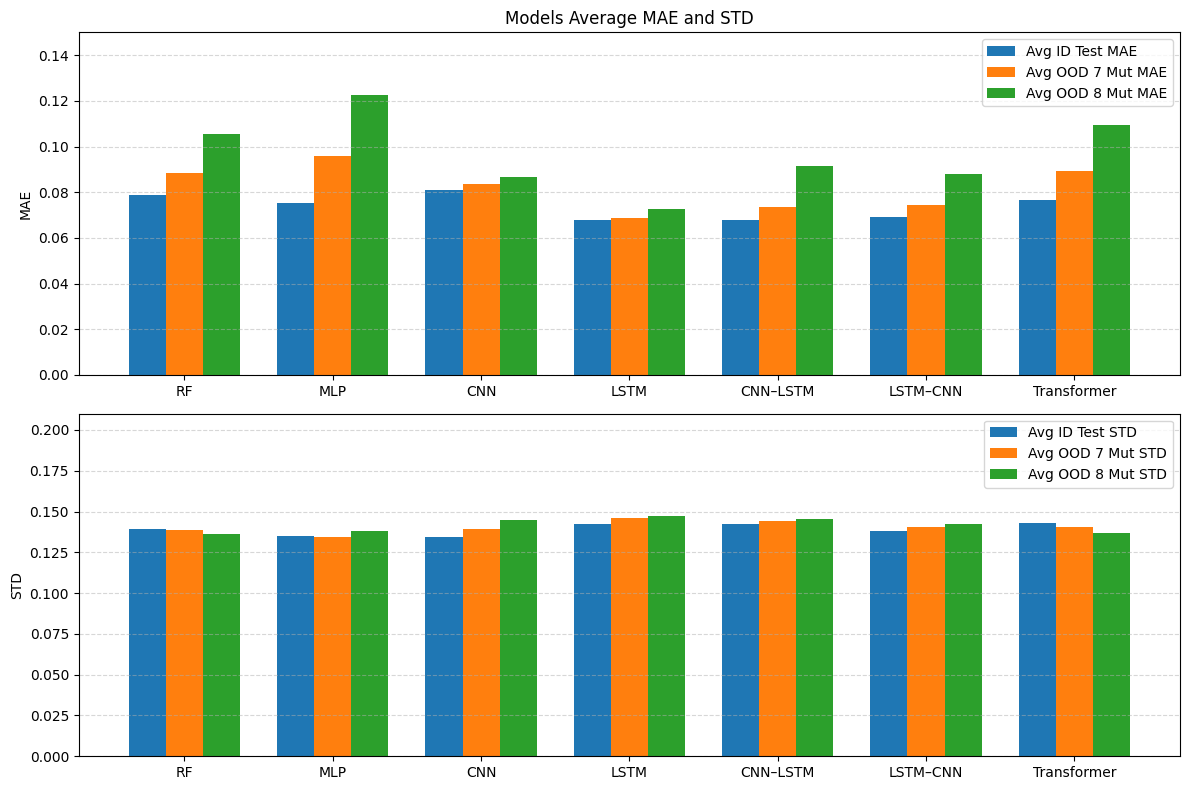

In [43]:
def plot_mae_with_y_gap(df, final_evaluation=False):

    label_map = {
        "rf": "RF",
        "mlp": "MLP",
        "cnn": "CNN",
        "lstm": "LSTM",
        "cnn_lstm": "CNN–LSTM",
        "lstm_cnn": "LSTM–CNN",
        "transformer": "Transformer"
    }

    labels = [label_map.get(m, m) for m in df_results_best["model"].tolist()]

    x = np.arange(len(labels))
    width = 0.25

    mae_sets = [
        ("ID Test MAE", "ID Test STD", df["test_mae"], df["test_std"]),
        ("OOD 7 Mut MAE", "OOD 7 Mut STD", df["ood_7_mut_mae"], df["ood_7_mut_std"]),
        ("OOD 8 Mut MAE", "OOD 8 Mut STD", df["ood_8_mut_mae"], df["ood_8_mut_std"])
    ] if not final_evaluation else [
        ("Avg ID Test MAE", "Avg ID Test STD", df["avg_test_mae"], df["avg_test_std"]),
        ("Avg OOD 7 Mut MAE", "Avg OOD 7 Mut STD", df["avg_ood_7_mut_mae"], df["avg_ood_7_mut_std"]),
        ("Avg OOD 8 Mut MAE", "Avg OOD 8 Mut STD", df["avg_ood_8_mut_mae"], df["avg_ood_8_mut_std"])
    ]

    colors = plt.cm.tab10(np.arange(len(mae_sets)))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    plt.subplots_adjust(hspace=0.15)

    for i, (label_mae, label_std, maes, stds) in enumerate(mae_sets):
        ax1.bar(x + (i - 1) * width, maes, width, label=label_mae, color=colors[i])
    
    ax1.set_ylabel("MAE")
    ax1.set_title("Models Average MAE and STD")
    ax1.legend(loc="upper right")
    ax1.grid(axis="y", linestyle="--", alpha=0.5)
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=0)
    ax1.tick_params(axis='x', labelbottom=True)

    for i, (label_mae, label_std, maes, stds) in enumerate(mae_sets):
        ax2.bar(x + (i - 1) * width, stds, width, color=colors[i], label=label_std)
    
    ax2.set_ylabel("STD")
    ax2.legend(loc="upper right")
    ax2.grid(axis="y", linestyle="--", alpha=0.5)

    ax2.set_xticks(x)
    ax2.set_xticklabels(labels, rotation=0)
    
    ax1.set_ylim(0, 0.15)
    ax2.set_ylim(0, 0.21)

    plt.tight_layout()
    plt.show()

plot_mae_with_y_gap(df_results_best, final_evaluation=True)

### Visual Analysis

In [44]:
load_models = True

In [45]:
mutation_data_dict = {}

for i in range(9):
    mutation_mask = (mutation_distances == i)
    cur_dict = {
        'x_data': x_data[mutation_mask],
        'y_data': y_data[mutation_mask]
    }
    mutation_data_dict[i] = cur_dict

In [46]:
import umap.umap_ as umap
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler

def fit_umap(x_onehot: np.ndarray, n_neighbors=10, min_dist=0.1, random_state=42, save_path="umap_model.pkl"):
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_onehot)

    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
    embedding = reducer.fit_transform(x_scaled)

    joblib.dump((reducer, scaler), save_path)
    return embedding

def get_umap_coords(x_all_onehot, umap_model_file):
    
    reducer, scaler = joblib.load(umap_model_file)
    x_scaled = scaler.transform(x_all_onehot)
    umap_coords = reducer.transform(x_scaled)
    
    return umap_coords

def transform_umap(x_onehot, load_path="umap_model.pkl"):
    reducer, scaler = joblib.load(load_path)
    x_scaled = scaler.transform(x_onehot)
    return reducer.transform(x_scaled)

def mutate_sequence(seq, n_mutations=1, num_classes=4):
    seq = seq.copy()
    indices = np.random.choice(len(seq), size=n_mutations, replace=False)
    for idx in indices:
        options = [x for x in range(num_classes) if x != seq[idx]]
        seq[idx] = np.random.choice(options)
    return seq

def evaluate_mutants(base_seq, model, f_true, num_mutations_list=[1, 2, 3], num_variants=50):
    results = []
    base_seq = base_seq.astype(int)
    for n_mut in num_mutations_list:
        for _ in range(num_variants):
            mutant = mutate_sequence(base_seq, n_mutations=n_mut)
            x_onehot = np.eye(4)[mutant].flatten().reshape(1, -1)
            y_pred = model(torch.tensor(x_onehot, dtype=torch.float32)).item()
            y_true = f_true(mutant.reshape(1, -1))[0]
            results.append((n_mut, y_true, y_pred, mutant))
    return results

def plot_fitness_landscape(embedding, fitness, title="Fitness", cmap='viridis'):
    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=fitness, cmap=cmap, s=10)
    plt.colorbar(label='Fitness')
    plt.title(title)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.tight_layout()
    plt.show()

def plot_umap_by_mutation(umap_coords, labels, target_mutations=(7, 8)):
    plt.figure(figsize=(8, 6))

    for mut_class in np.unique(labels):
        coords = umap_coords[labels == mut_class]
        if mut_class in target_mutations:
            plt.scatter(coords[:, 0], coords[:, 1], label=f"{mut_class} mutations", s=10)
        else:
            plt.scatter(coords[:, 0], coords[:, 1], color="lightgrey", alpha=0.2, s=5)

    plt.legend()
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.title("UMAP Clustering by Mutation Count")
    plt.tight_layout()
    plt.show()

C:\Users\kroep\anaconda3\envs\ps_msc\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [47]:
x_all = np.concatenate([v['x_data'] for v in mutation_data_dict.values()])
mutation_labels = np.concatenate([
    np.full(len(v['x_data']), mut_class) for mut_class, v in mutation_data_dict.items()
])

x_all_onehot = np.eye(4)[x_all].reshape(len(x_all), -1)

In [48]:
x_id = np.concatenate([
    v['x_data'] for i, v in enumerate(mutation_data_dict.values())
    if i not in [7, 8]
])

mutation_labels_id = np.concatenate([
    np.full(len(v['x_data']), mut_class)
    for i, (mut_class, v) in enumerate(mutation_data_dict.items())
    if i not in [7, 8]
])

x_id_onehot = np.eye(4)[x_id].reshape(len(x_id), -1)

In [49]:
x_ood = np.concatenate([
    v['x_data'] for i, v in enumerate(mutation_data_dict.values())
    if i in [7, 8]
])

mutation_labels_ood = np.concatenate([
    np.full(len(v['x_data']), mut_class)
    for i, (mut_class, v) in enumerate(mutation_data_dict.items())
    if i in [7, 8]
])

x_ood_onehot = np.eye(4)[x_ood].reshape(len(x_ood), -1)

In [50]:
np.shape(x_all_onehot), np.shape(x_id_onehot), np.shape(x_ood_onehot)

((65536, 32), (41479, 32), (24057, 32))

In [27]:
if not load_models:
    for n_neighbors in [10, 30, 50, 100, 150, 200]:
        for min_dist in [0, 0.1, 0.2, 0.3, 0.5]:
            
            save_path = f"umap_models\\umap_{n_neighbors}_neighbors_{str(min_dist).replace('.', '')}_min_dist.pkl"
            print(save_path)
            
            umap_coords = fit_umap(
                x_id_onehot, n_neighbors=n_neighbors, min_dist=min_dist, save_path=save_path
            )
            
if not load_models:
    for n_neighbors in [10, 30, 50, 100, 150, 200]:
        for min_dist in [0, 0.1, 0.2, 0.3, 0.5]:
            
            save_path = f"umap_models\\umap_{n_neighbors}_neighbors_{str(min_dist).replace('.', '')}_min_dist_all_x.pkl"
            print(save_path)
            
            umap_coords = fit_umap(
                x_all_onehot, n_neighbors=n_neighbors, min_dist=min_dist, save_path=save_path
            )
            
# save_path = r"umap_models\umap_29_neighbors_01_min_dist.pkl"
umap_coords_ood = transform_umap(x_ood_onehot, load_path=save_path)
umap_coords = np.concatenate([umap_coords, umap_coords_ood], axis=0)

In [94]:
'''if True:
    root_dir = "umap_models"
    file_set = set()

    for dir_, _, files in os.walk(root_dir):
        for file_name in files:
            rel_dir = os.path.relpath(dir_, root_dir)
            rel_file = os.path.join(rel_dir, file_name)
            file_set.add(rel_file)

    file_list = [os.path.join(root_dir, file.split('\\')[-1]) for file in list(file_set)]
    
    umap_coords_dict = {}
    
    for file in file_list:

        umap_coords = get_umap_coords(
            x_all_onehot=x_all_onehot,
            umap_model_file=file
        )
        
        umap_coords_dict[file] = umap_coords
        
        # plot_umap_by_mutation(umap_coords_sampled, mutation_labels, target_mutations=(7, 8))
    '''

'if True:\n    root_dir = "umap_models"\n    file_set = set()\n\n    for dir_, _, files in os.walk(root_dir):\n        for file_name in files:\n            rel_dir = os.path.relpath(dir_, root_dir)\n            rel_file = os.path.join(rel_dir, file_name)\n            file_set.add(rel_file)\n\n    file_list = [os.path.join(root_dir, file.split(\'\\\')[-1]) for file in list(file_set)]\n\n    umap_coords_dict = {}\n\n    for file in file_list:\n\n        umap_coords = get_umap_coords(\n            x_all_onehot=x_all_onehot,\n            umap_model_file=file\n        )\n\n        umap_coords_dict[file] = umap_coords\n\n        # plot_umap_by_mutation(umap_coords_sampled, mutation_labels, target_mutations=(7, 8))\n    '

In [52]:
umap_coords = get_umap_coords(
    x_all_onehot=x_all_onehot,
    umap_model_file='umap_models\\umap_150_neighbors_01_min_dist.pkl'
)

In [53]:
umap_coords_all_x = get_umap_coords(
    x_all_onehot=x_all_onehot,
    umap_model_file='umap_models\\umap_150_neighbors_01_min_dist_all_x.pkl'
)

In [95]:
def plot_umap_by_mutation_split(umap_coords, labels, split_ood=False, share_axes=False):
    
    # Colors
    color_id = "dimgray"  # dark grey for ID (1–6)
    color_7  = "#1f77b4"  # blue
    color_8  = "#ff7f0e"  # orange
    color_bg_id = "lightgrey"  # ID as background in lightgrey

    s_id_fg = 8
    s_id_bg = 8
    s_ood = 12
    
    alpha_id_fg = 0.7  # ID  top left
    alpha_id_bg = 0.4  # ID background right
    alpha_7_bg  = 0.5  # 7 as background left
    alpha_8_bg  = 0.5  # 8 as background left
    
    mask_id = labels < 7
    mask_7  = labels == 7
    mask_8  = labels == 8

    # Layout
    if split_ood:
        fig, axes = plt.subplots(1, 3, figsize=(21, 7))
        titles = [
            "In-Distribution (1–6 mutations)",
            "Out-of-Distribution (7 mutations)",
            "Out-of-Distribution (8 mutations)"
        ]
    else:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        titles = [
            "In-Distribution (1–6 mutations)",
            "Out-of-Distribution (7–8 mutations)"
        ]

    if share_axes:
        x_min, x_max = np.min(umap_coords[:, 0]), np.max(umap_coords[:, 0])
        y_min, y_max = np.min(umap_coords[:, 1]), np.max(umap_coords[:, 1])

    def order_legend(ax):
        handles, labels_txt = ax.get_legend_handles_labels()
        order_map = {"ID (1–6 mutations)": 0, "7 mutations (OOD)": 1, "8 mutations (OOD)": 2}
        order = np.argsort([order_map.get(t, 99) for t in labels_txt])
        ax.legend([handles[i] for i in order], [labels_txt[i] for i in order],
                  title="Mutation Category", loc="best")

    for ax, title in zip(axes, titles):
        if "In-Distribution" in title:
            if np.any(mask_8):
                ax.scatter(umap_coords[mask_8, 0], umap_coords[mask_8, 1],
                           color=color_8, alpha=alpha_8_bg, s=s_id_bg, zorder=1,
                           edgecolors="none", label="8 mutations (OOD)")
            if np.any(mask_7):
                ax.scatter(umap_coords[mask_7, 0], umap_coords[mask_7, 1],
                           color=color_7, alpha=alpha_7_bg, s=s_id_bg, zorder=2,
                           edgecolors="none", label="7 mutations (OOD)")
            if np.any(mask_id):
                ax.scatter(umap_coords[mask_id, 0], umap_coords[mask_id, 1],
                           color=color_id, alpha=alpha_id_fg, s=s_id_fg, zorder=3,
                           edgecolors="none", label="ID (1–6 mutations)")

        elif "7–8" in title:
            if np.any(mask_id):
                ax.scatter(umap_coords[mask_id, 0], umap_coords[mask_id, 1],
                           color=color_bg_id, alpha=alpha_id_bg, s=s_id_bg, zorder=1,
                           edgecolors="none", label="ID (1–6 mutations)")
            if np.any(mask_8):
                ax.scatter(umap_coords[mask_8, 0], umap_coords[mask_8, 1],
                           color=color_8, s=s_ood, zorder=3,
                           edgecolors="none", label="8 mutations (OOD)")
            if np.any(mask_7):
                ax.scatter(umap_coords[mask_7, 0], umap_coords[mask_7, 1],
                           color=color_7, s=s_ood, zorder=3,
                           edgecolors="none", label="7 mutations (OOD)")

        elif "7 mutations" in title:
            if np.any(mask_id):
                ax.scatter(umap_coords[mask_id, 0], umap_coords[mask_id, 1],
                           color=color_bg_id, alpha=alpha_id_bg, s=s_id_bg, zorder=1,
                           edgecolors="none", label="ID (1–6 mutations)")
            if np.any(mask_7):
                ax.scatter(umap_coords[mask_7, 0], umap_coords[mask_7, 1],
                           color=color_7, s=s_ood, zorder=3,
                           edgecolors="none", label="7 mutations (OOD)")
        
        elif "8 mutations" in title:
            if np.any(mask_id):
                ax.scatter(umap_coords[mask_id, 0], umap_coords[mask_id, 1],
                           color=color_bg_id, alpha=alpha_id_bg, s=s_id_bg, zorder=1,
                           edgecolors="none", label="ID (1–6 mutations)")
            if np.any(mask_8):
                ax.scatter(umap_coords[mask_8, 0], umap_coords[mask_8, 1],
                           color=color_8, s=s_ood, zorder=3,
                           edgecolors="none", label="8 mutations (OOD)")

        ax.set_title(title)
        ax.set_xlabel("UMAP-1")
        ax.set_ylabel("UMAP-2")

        if share_axes:
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)

        order_legend(ax)

    plt.tight_layout()
    plt.show()

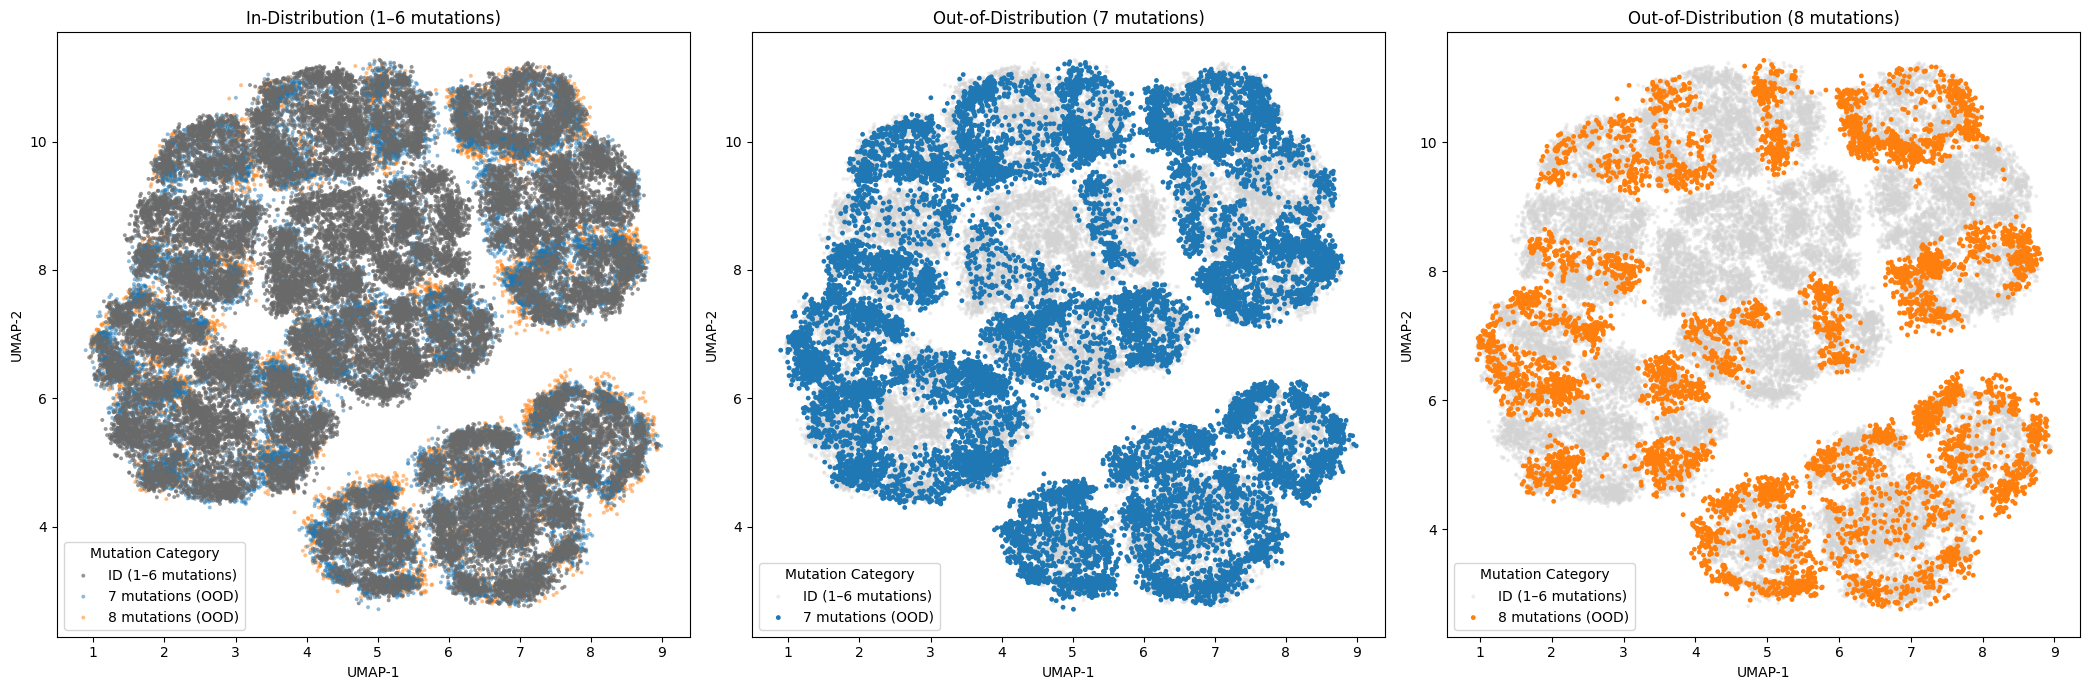

In [96]:
plot_umap_by_mutation_split(
    umap_coords, mutation_labels, split_ood=True
)

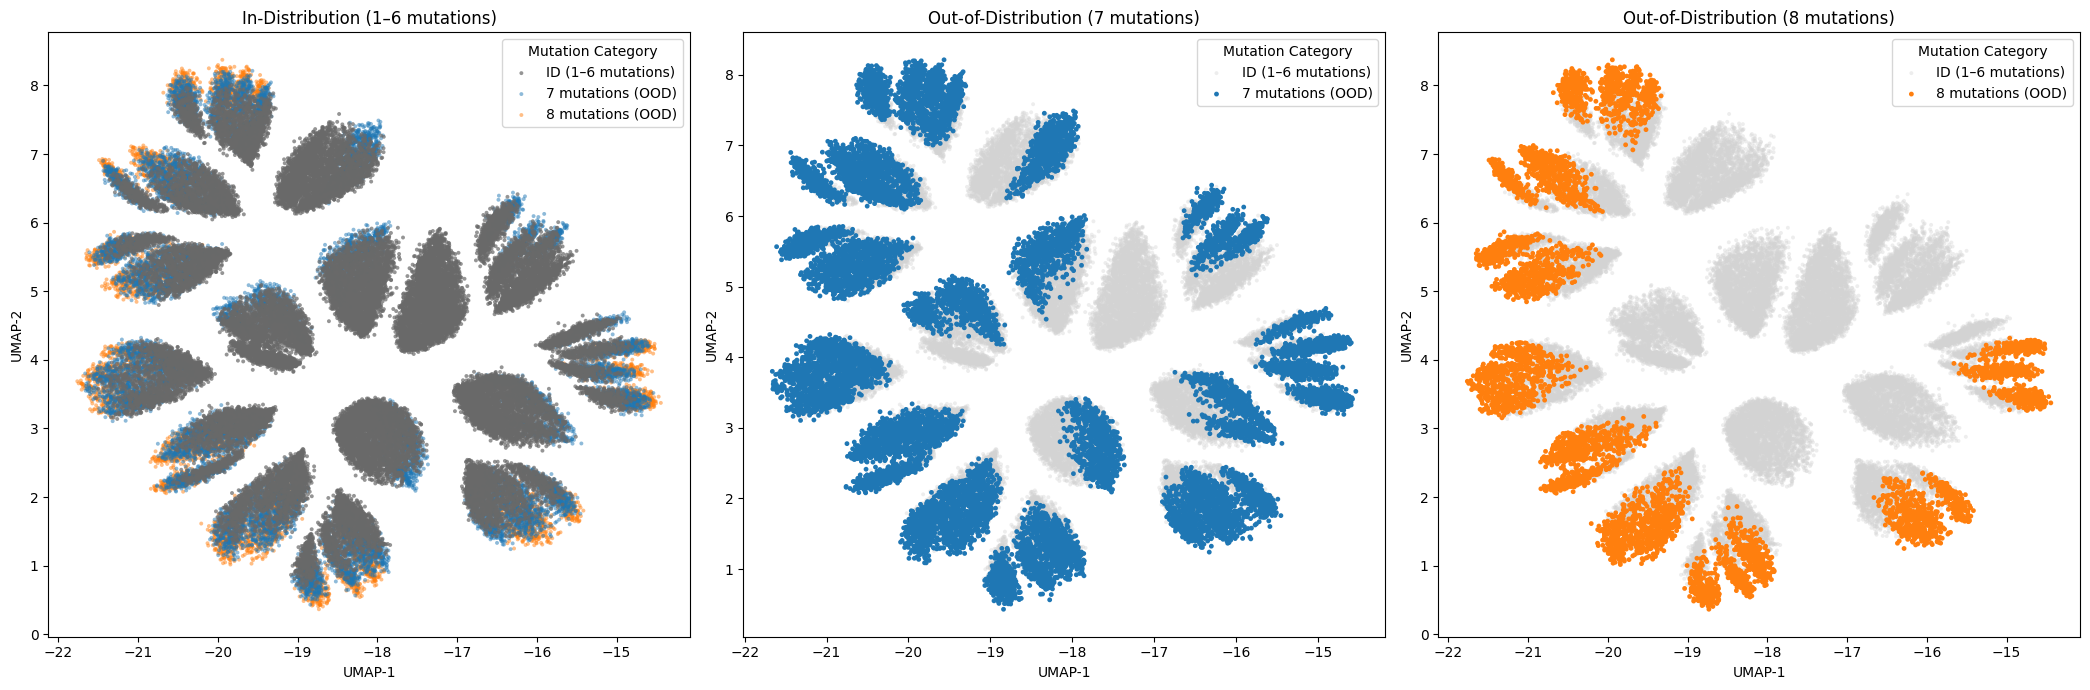

In [56]:
plot_umap_by_mutation_split(
    umap_coords_all_x, mutation_labels, split_ood=True
)

In [55]:
# [i for i, (x, y) in enumerate(umap_coords_all_x) if x>-17 and y<2.5]

In [52]:
[[float(x), float(y)] for x, y in umap_coords_all_x if x>-17 and y<2.5]

4080

In [98]:
def plot_umap_cluster_comparison_same_scaling(
    umap_coords,
    umap_coords_all_x,
    labels,
    cond_fn=lambda x, y: (x > -17) and (y < 2.5),
):
    
    # left:  selected cluster in umap_coords_all_x
    # right: same indices in umap_coords

    mask_cluster = np.array([cond_fn(x, y) for x, y in umap_coords_all_x])
    idx_cluster = np.where(mask_cluster)[0]

    if idx_cluster.size == 0:
        print("No points satisfy the cluster condition.")
        return idx_cluster, None, None

    coords_all_cluster = umap_coords_all_x[idx_cluster]
    coords_ref_cluster = umap_coords[idx_cluster]
    labels_cluster     = labels[idx_cluster]

    color_id = "dimgray"  # dark grey for ID (1–6)
    color_7  = "#1f77b4"  # blue
    color_8  = "#ff7f0e"  # orange

    s_id_fg = 8
    s_ood   = 12

    alpha_id_fg = 0.7
    alpha_7_fg  = 0.7
    alpha_8_fg  = 0.7

    mask_id_c = labels_cluster < 7
    mask_7_c  = labels_cluster == 7
    mask_8_c  = labels_cluster == 8

    x_min_all = np.min(umap_coords_all_x[:, 0])
    x_max_all = np.max(umap_coords_all_x[:, 0])
    y_min_all = np.min(umap_coords_all_x[:, 1])
    y_max_all = np.max(umap_coords_all_x[:, 1])

    x_min_ref = np.min(umap_coords[:, 0])
    x_max_ref = np.max(umap_coords[:, 0])
    y_min_ref = np.min(umap_coords[:, 1])
    y_max_ref = np.max(umap_coords[:, 1])

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    def order_legend(ax):
        handles, labels_txt = ax.get_legend_handles_labels()
        order_map = {
            "ID (1–6 mutations)": 0,
            "7 mutations (OOD)": 1,
            "8 mutations (OOD)": 2
        }
        order = np.argsort([order_map.get(t, 99) for t in labels_txt])
        ax.legend(
            [handles[i] for i in order],
            [labels_txt[i] for i in order],
            title="Mutation Category",
            loc="best"
        )

    ax = axes[0]

    if np.any(mask_id_c):
        ax.scatter(
            coords_all_cluster[mask_id_c, 0],
            coords_all_cluster[mask_id_c, 1],
            color=color_id,
            alpha=alpha_id_fg,
            s=s_id_fg,
            edgecolors="none",
            label="ID (1–6 mutations)"
        )
    if np.any(mask_7_c):
        ax.scatter(
            coords_all_cluster[mask_7_c, 0],
            coords_all_cluster[mask_7_c, 1],
            color=color_7,
            alpha=alpha_7_fg,
            s=s_ood,
            edgecolors="none",
            label="7 mutations (OOD)"
        )
    if np.any(mask_8_c):
        ax.scatter(
            coords_all_cluster[mask_8_c, 0],
            coords_all_cluster[mask_8_c, 1],
            color=color_8,
            alpha=alpha_8_fg,
            s=s_ood,
            edgecolors="none",
            label="8 mutations (OOD)"
        )

    ax.set_title("Cluster in UMAP (all_x embedding)")
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_xlim(x_min_all, x_max_all)
    ax.set_ylim(y_min_all, y_max_all)
    order_legend(ax)

    ax = axes[1]

    if np.any(mask_id_c):
        ax.scatter(
            coords_ref_cluster[mask_id_c, 0],
            coords_ref_cluster[mask_id_c, 1],
            color=color_id,
            alpha=alpha_id_fg,
            s=s_id_fg,
            edgecolors="none",
            label="ID (1–6 mutations)"
        )
    if np.any(mask_7_c):
        ax.scatter(
            coords_ref_cluster[mask_7_c, 0],
            coords_ref_cluster[mask_7_c, 1],
            color=color_7,
            alpha=alpha_7_fg,
            s=s_ood,
            edgecolors="none",
            label="7 mutations (OOD)"
        )
    if np.any(mask_8_c):
        ax.scatter(
            coords_ref_cluster[mask_8_c, 0],
            coords_ref_cluster[mask_8_c, 1],
            color=color_8,
            alpha=alpha_8_fg,
            s=s_ood,
            edgecolors="none",
            label="8 mutations (OOD)"
        )

    ax.set_title("Same cluster in reference UMAP")
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_xlim(x_min_ref, x_max_ref)
    ax.set_ylim(y_min_ref, y_max_ref)
    order_legend(ax)

    plt.tight_layout()
    plt.show()

    return idx_cluster, coords_all_cluster, coords_ref_cluster

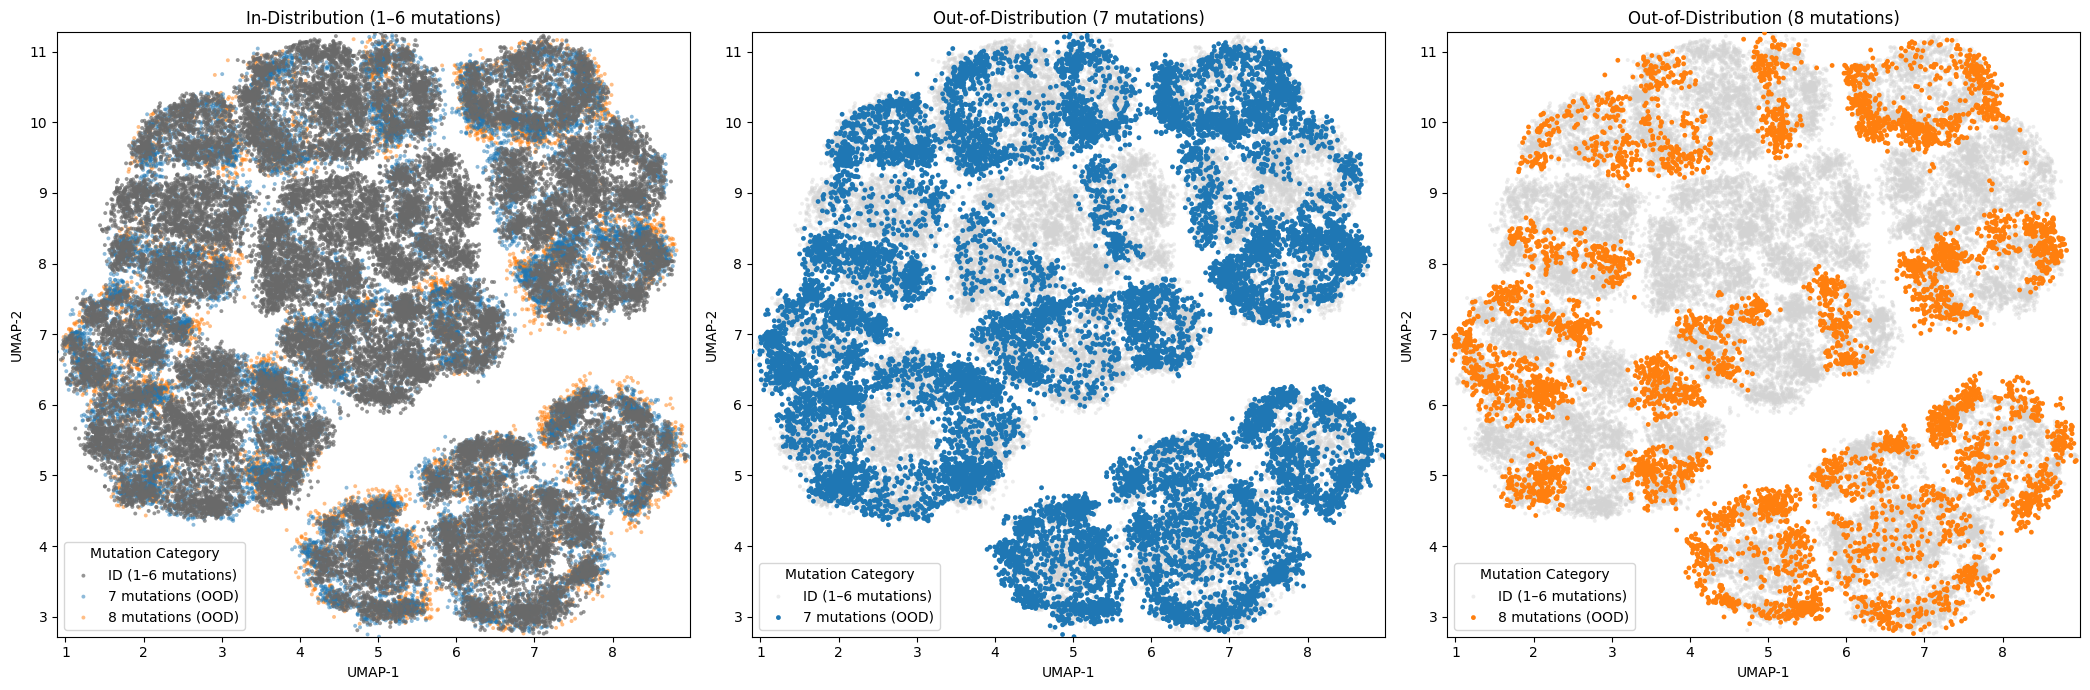

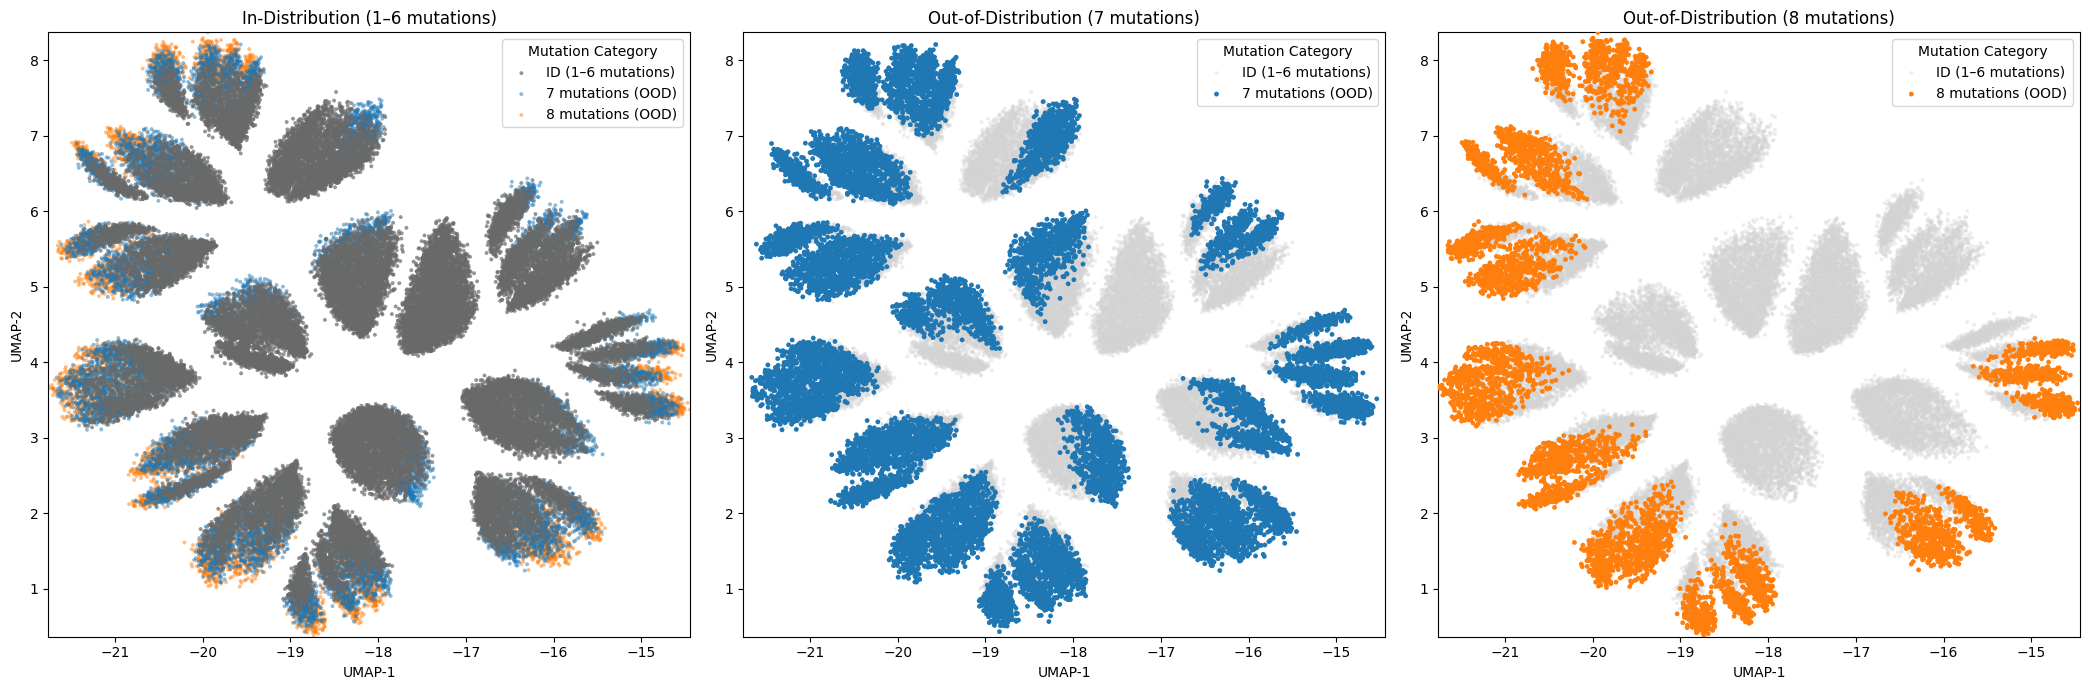

In [99]:
plot_umap_by_mutation_split(umap_coords,       mutation_labels, split_ood=True, share_axes=True)
plot_umap_by_mutation_split(umap_coords_all_x, mutation_labels, split_ood=True, share_axes=True)

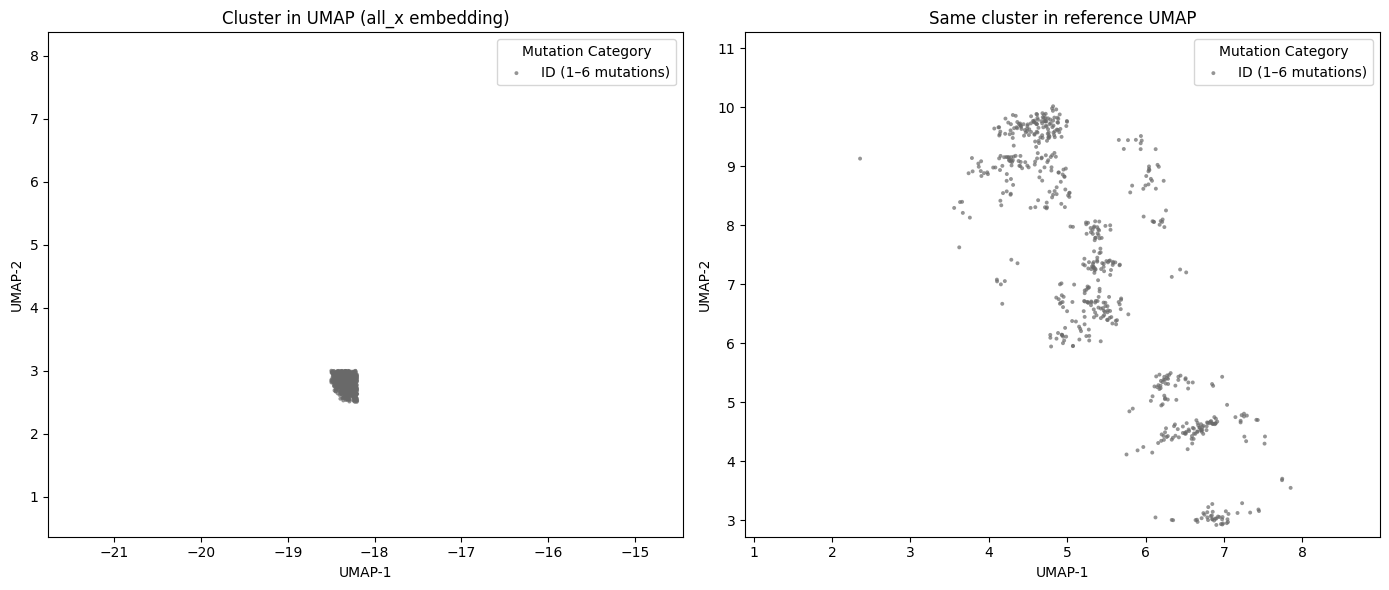

In [100]:
idx_cluster, all_x_cluster, ref_cluster = plot_umap_cluster_comparison_same_scaling(
    umap_coords=umap_coords,
    umap_coords_all_x=umap_coords_all_x,
    labels=mutation_labels,
    cond_fn=lambda x, y: (x < -18.2) and (x > -18.5) and (y > 2.5) and (y < 3),
)

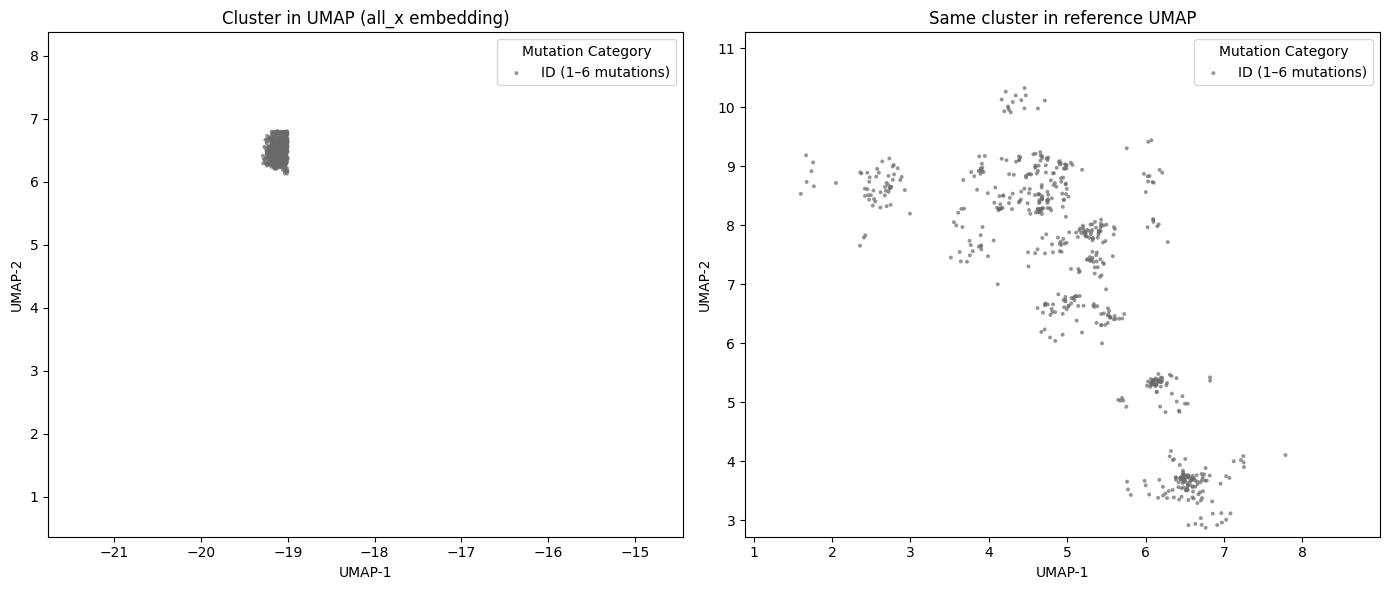

In [101]:
idx_cluster, all_x_cluster, ref_cluster = plot_umap_cluster_comparison_same_scaling(
    umap_coords=umap_coords,
    umap_coords_all_x=umap_coords_all_x,
    labels=mutation_labels,
    cond_fn=lambda x, y: (x > -19.3) and (x < -19) and (y > 6) and (y < 6.8),
)

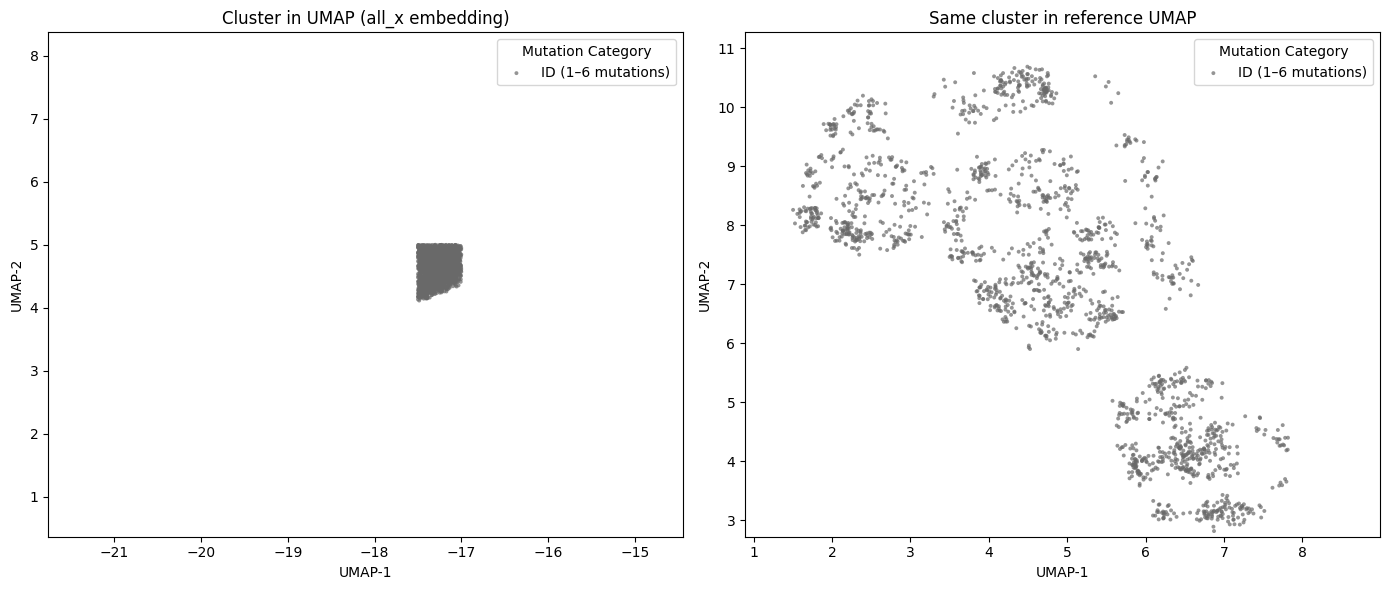

In [102]:
idx_cluster, all_x_cluster, ref_cluster = plot_umap_cluster_comparison_same_scaling(
    umap_coords=umap_coords,
    umap_coords_all_x=umap_coords_all_x,
    labels=mutation_labels,
    cond_fn=lambda x, y: (x > -17.5) and (x < -17) and (y > 4) and (y < 5),
)

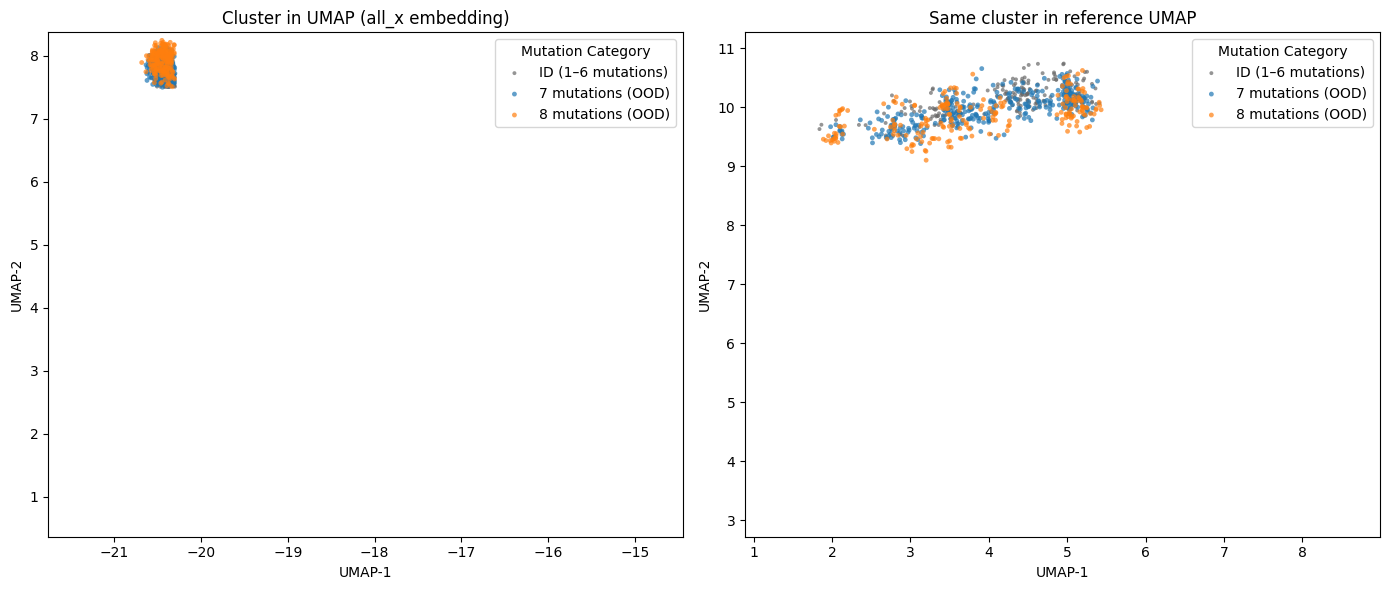

In [103]:
idx_cluster, all_x_cluster, ref_cluster = plot_umap_cluster_comparison_same_scaling(
    umap_coords=umap_coords,
    umap_coords_all_x=umap_coords_all_x,
    labels=mutation_labels,
    cond_fn=lambda x, y: (x < -20.3) and (y > 7.5),
)

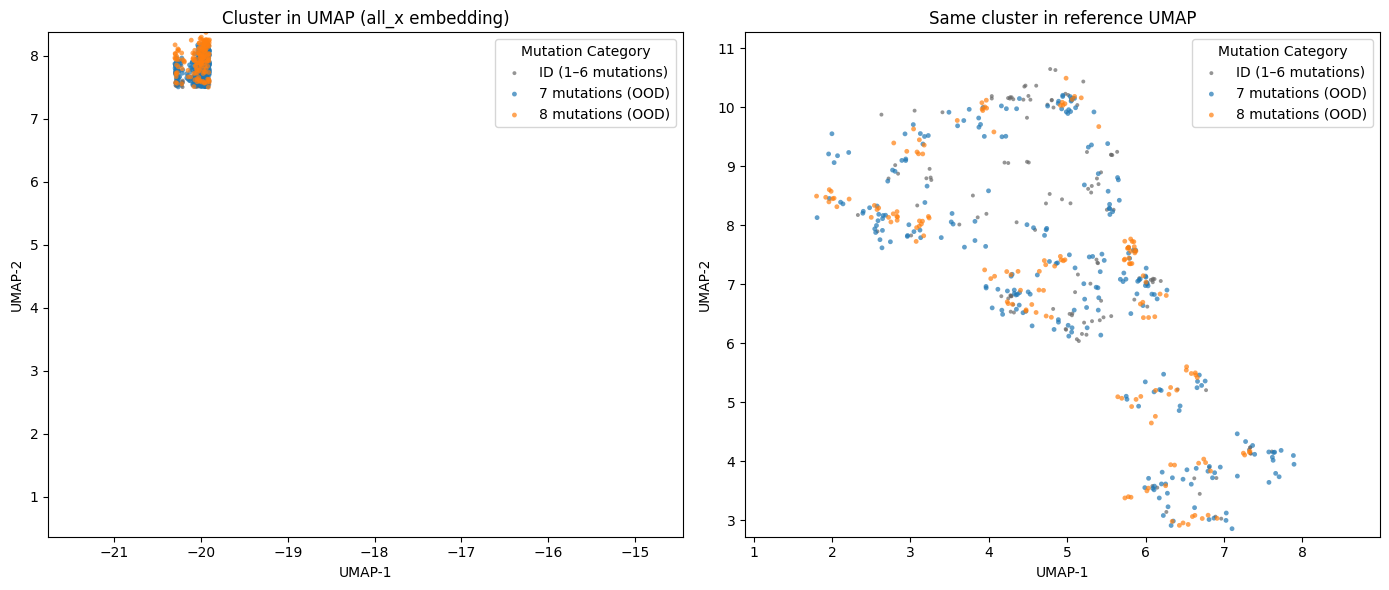

In [104]:
idx_cluster, all_x_cluster, ref_cluster = plot_umap_cluster_comparison_same_scaling(
    umap_coords=umap_coords,
    umap_coords_all_x=umap_coords_all_x,
    labels=mutation_labels,
    cond_fn=lambda x, y: (x > -20.3) and (x < -19.9) and (y > 7.5),
)

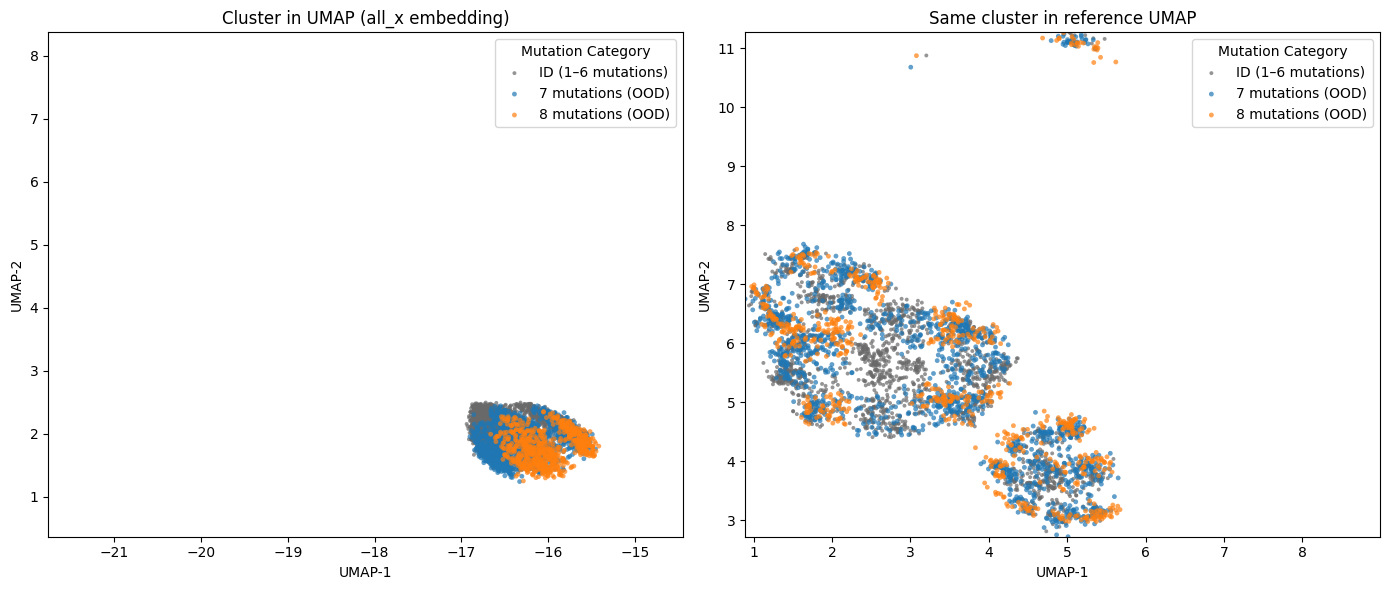

In [105]:
idx_cluster, all_x_cluster, ref_cluster = plot_umap_cluster_comparison_same_scaling(
    umap_coords=umap_coords,
    umap_coords_all_x=umap_coords_all_x,
    labels=mutation_labels,
    cond_fn=lambda x, y: (x > -17) and (y < 2.5),
)

In [107]:
'''for file in umap_coords_dict.keys():
    if file.split('.')[0].split('_')[-1] != 'x':
        print(file)
        
        plot_umap_by_mutation_split(
            umap_coords_dict[file], mutation_labels, split_ood=True
        )'''

"for file in umap_coords_dict.keys():\n    if file.split('.')[0].split('_')[-1] != 'x':\n        print(file)\n\n        plot_umap_by_mutation_split(\n            umap_coords_dict[file], mutation_labels, split_ood=True\n        )"

In [108]:
'''# choose the best representation
umap_coords = umap_coords_dict['umap_models\\umap_150_neighbors_01_min_dist.pkl']
umap_coords'''

"# choose the best representation\numap_coords = umap_coords_dict['umap_models\\umap_150_neighbors_01_min_dist.pkl']\numap_coords"

### Fitness Landscape

In [85]:
mutation_data_dict = {}

for i in range(9):
    mutation_mask = (mutation_distances == i)
    cur_dict = {
        'x_data': x_data[mutation_mask],
        'y_data': y_data[mutation_mask]
    }
    mutation_data_dict[i] = cur_dict

In [86]:
x_all = np.concatenate([v['x_data'] for v in mutation_data_dict.values()])
y_all = np.concatenate([v['y_data'] for v in mutation_data_dict.values()])

mutation_labels = np.concatenate([
    np.full(len(v['x_data']), mut_class) for mut_class, v in mutation_data_dict.items()
])

x_all_onehot = np.eye(4)[x_all].reshape(len(x_all), -1)

In [87]:
y_pred_all = predict_y_values(
    folder='results\\training\\random_search_2025-10-02-08-04',
    model_names=['lstm'],
    x_test=x_all
)

Predicting with model: lstm


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:289: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_encoded_torch = torch.tensor(X_test_encoded, dtype=torch.float32).to(device)


 → Done: lstm, predicted 65536 samples.


In [88]:
len(x_all) == len(mutation_labels) == len(y_pred_all['lstm'])

True

In [109]:
def plot_umap_true_vs_pred(
    umap_coords,
    mutation_labels,
    selected_mutations,
    y_true,
    y_pred,
    cmap="viridis",
    figsize=(12, 10),
    use_abs_error=False,
    id_color="lightgrey",
    id_alpha=0.1,
    id_size=10
):
    
    mask = np.isin(mutation_labels, selected_mutations)
    if not np.any(mask):
        print(f"No samples found for mutation classes {selected_mutations}")
        return

    mask_id = (mutation_labels >= 1) & (mutation_labels <= 6)

    Z      = np.asarray(umap_coords)[mask]
    y_t    = np.ravel(np.asarray(y_true)[mask])
    y_p    = np.ravel(np.asarray(y_pred)[mask])

    Z_id = np.asarray(umap_coords)[mask_id]

    if Z.shape[0] != y_t.shape[0]:
        print(f"Shape mismatch: points={Z.shape[0]}, y_true={y_t.shape[0]}")
        return
    
    diff = np.abs(y_p - y_t) if use_abs_error else (y_p - y_t)

    vmin = np.min([y_t.min(), y_p.min()])
    vmax = np.max([y_t.max(), y_p.max()])

    if use_abs_error:
        dmin, dmax = 0.0, diff.max()
        diff_cmap = "viridis"
        diff_label = "Absolute error"
    else:
        dmax = np.max(np.abs(diff))
        dmin, dmax = -dmax, dmax
        diff_cmap = "coolwarm"
        diff_label = "Binding Affinity Prediction Difference"

    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[1, 1.2])

    ax_true = fig.add_subplot(gs[0, 0])
    ax_pred = fig.add_subplot(gs[0, 1])
    ax_diff = fig.add_subplot(gs[1, :])

    ax_true.scatter(
        Z_id[:, 0], Z_id[:, 1],
        color=id_color, alpha=id_alpha, s=id_size,
        edgecolors="none"
    )

    sc1 = ax_true.scatter(
        Z[:, 0], Z[:, 1], c=y_t,
        cmap=cmap, s=15, vmin=vmin, vmax=vmax
    )
    ax_true.set_title(f"True Binding Affinity for {selected_mutations} mutations")
    ax_true.set_xlabel("UMAP-1")
    ax_true.set_ylabel("UMAP-2")

    ax_pred.scatter(
        Z_id[:, 0], Z_id[:, 1],
        color=id_color, alpha=id_alpha, s=id_size,
        edgecolors="none"
    )

    sc2 = ax_pred.scatter(
        Z[:, 0], Z[:, 1], c=y_p,
        cmap=cmap, s=15, vmin=vmin, vmax=vmax
    )
    ax_pred.set_title(f"Predicted Binding Affinity for {selected_mutations} mutations")
    ax_pred.set_xlabel("UMAP-1")
    ax_pred.set_ylabel("UMAP-2")

    sc3 = ax_diff.scatter(
        Z[:, 0], Z[:, 1], c=diff,
        cmap=diff_cmap, s=20, vmin=dmin, vmax=dmax
    )
    ax_diff.set_title(f"{diff_label} (Pred − True)")
    ax_diff.set_xlabel("UMAP-1")
    ax_diff.set_ylabel("UMAP-2")

    fig.colorbar(sc2, ax=[ax_true, ax_pred], shrink=0.8, label="Binding Affinity Value")
    fig.colorbar(sc3, ax=ax_diff, shrink=0.8, label=diff_label)

    id_legend_entry = Line2D(
        [0], [0], 
        marker='o', 
        color=id_color, 
        markersize=8, 
        linestyle='None', 
        alpha=id_alpha,
        label="ID data points"
    )

    ax_true.legend(handles=[id_legend_entry], loc='best')
    ax_pred.legend(handles=[id_legend_entry], loc='best')

    plt.show()

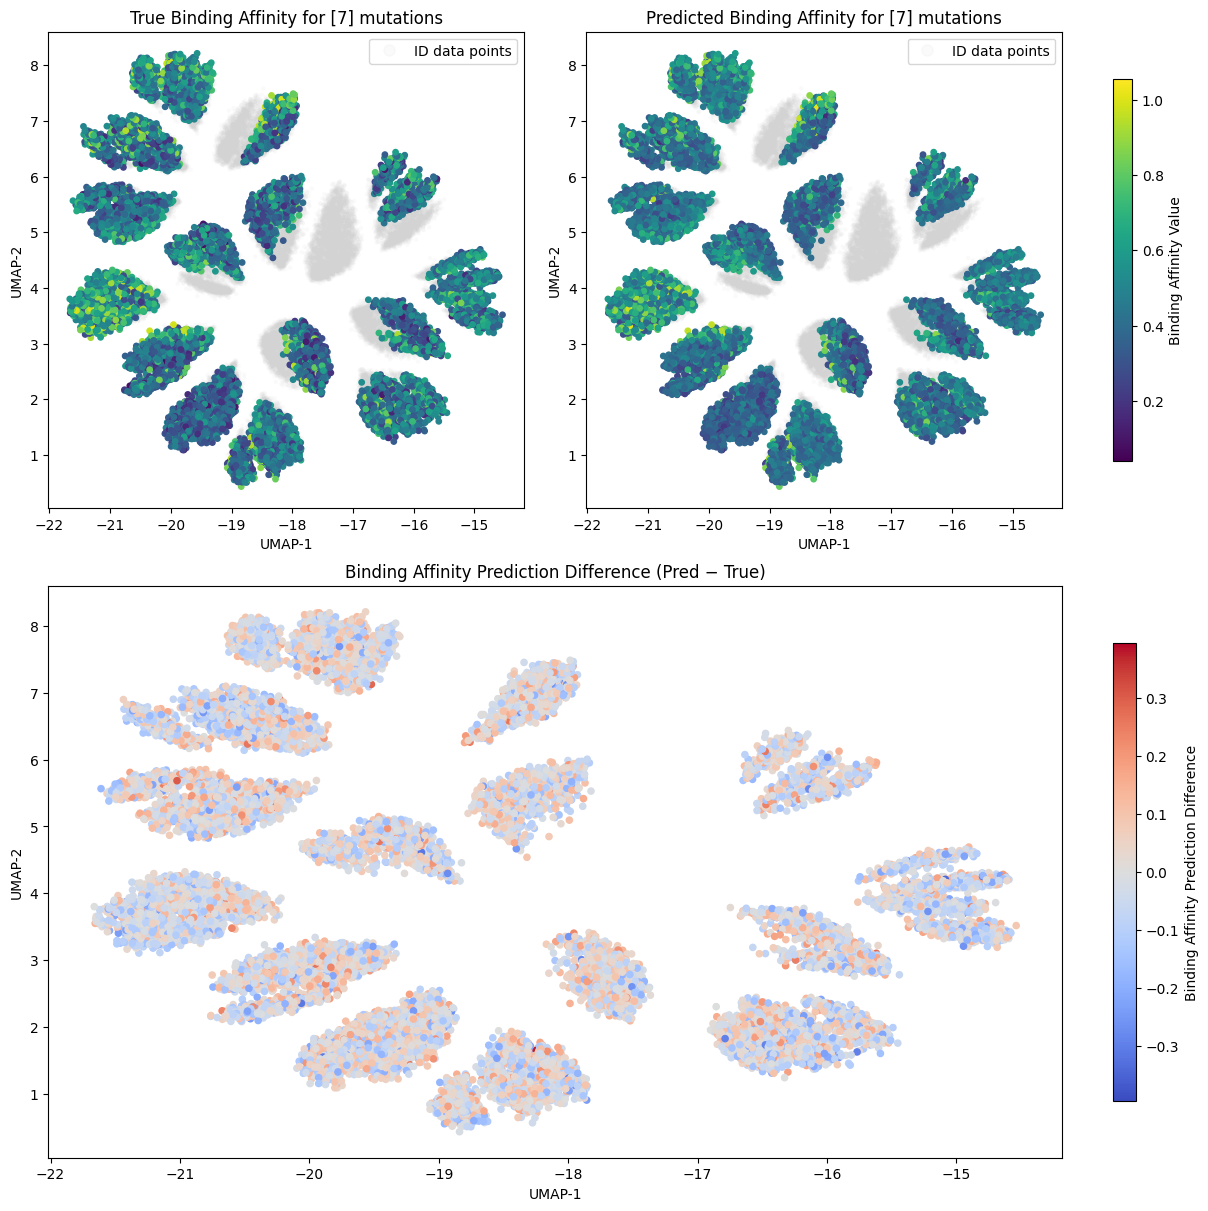

In [110]:
plot_umap_true_vs_pred(
    # umap_coords,
    umap_coords_all_x,
    mutation_labels,
    selected_mutations=[7],
    y_true=y_all,
    y_pred=y_pred_all['lstm'],
    figsize=(12, 12)
) 

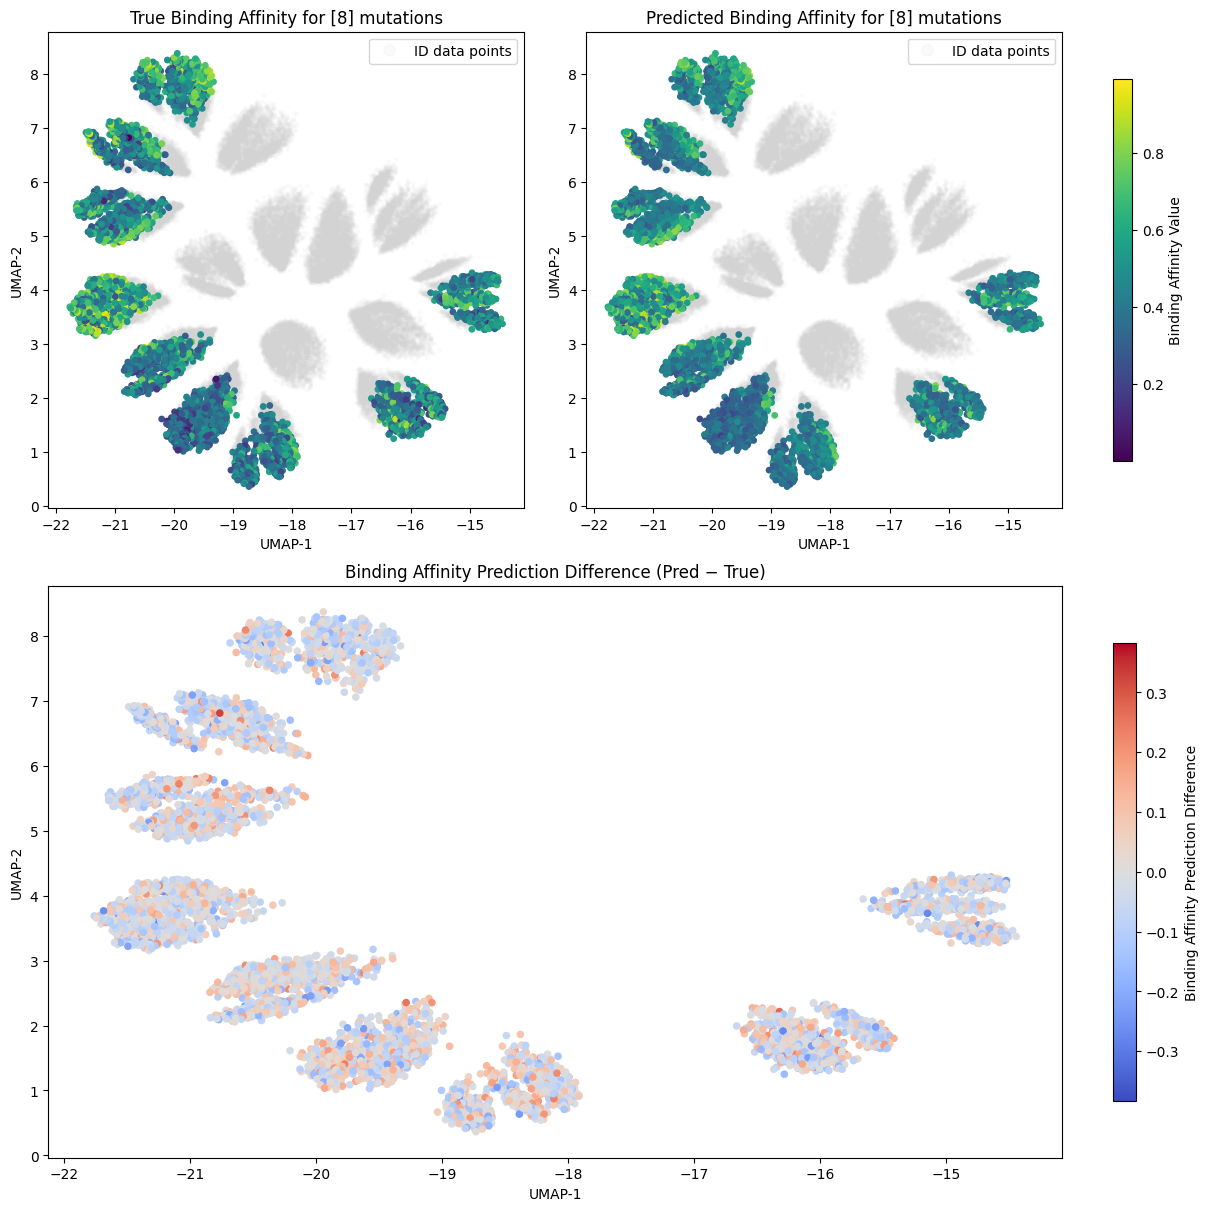

In [111]:
plot_umap_true_vs_pred(
    # umap_coords,
    umap_coords_all_x,
    mutation_labels,
    selected_mutations=[8],
    y_true=y_all,
    y_pred=y_pred_all['lstm'],
    figsize=(12, 12)
) 

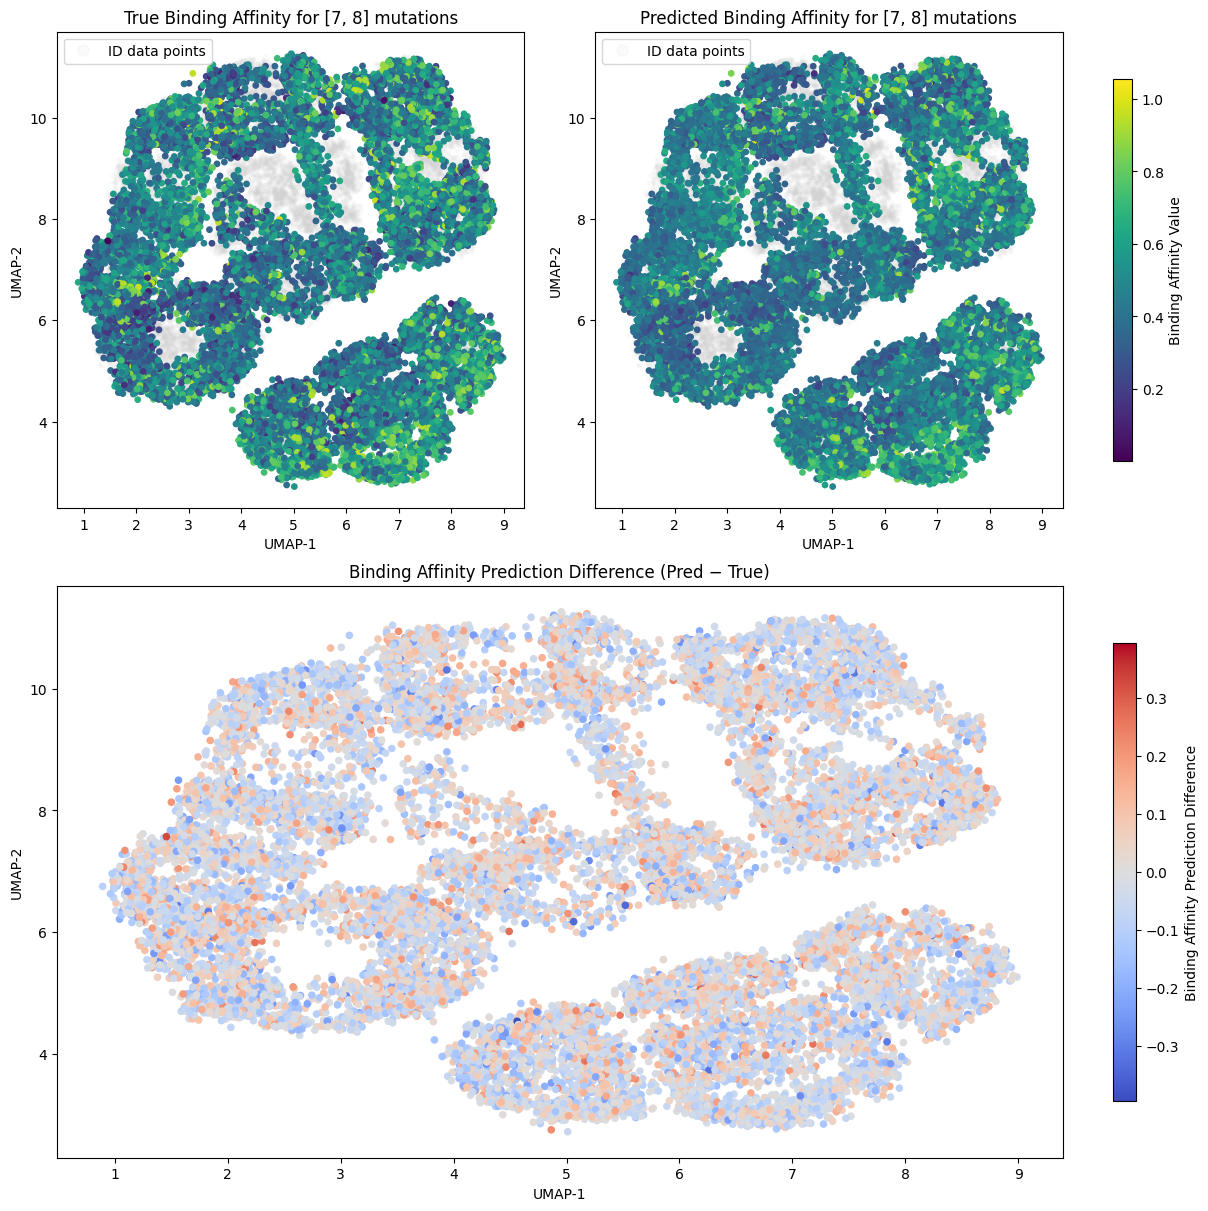

In [112]:
plot_umap_true_vs_pred(
    umap_coords,
    mutation_labels,
    selected_mutations=[7,8],
    y_true=y_all,
    y_pred=y_pred_all['lstm'],
    figsize=(12, 12)
)

#### CNN-LSTM

In [113]:
y_pred_all = predict_y_values(
    folder='results\\training\\random_search_2025-10-02-08-04',
    model_names=['cnn_lstm'],
    x_test=x_all
)

Predicting with model: cnn_lstm


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
len(x_all) == len(mutation_labels) == len(y_pred_all['cnn_lstm'])

In [ ]:
plot_umap_true_vs_pred(
    umap_coords,
    mutation_labels,
    selected_mutations=[7],
    y_true=y_all,
    y_pred=y_pred_all['cnn_lstm'],
    figsize=(12, 12)
) 

In [ ]:
plot_umap_true_vs_pred(
    umap_coords,
    mutation_labels,
    selected_mutations=[8],
    y_true=y_all,
    y_pred=y_pred_all['cnn_lstm'],
    figsize=(12, 12)
) 